In [1]:
import ipaddress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import timedelta
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)

# IPv4 Address Space Classification

In [3]:
CSV2013 = 'combined_2013.csv'
CSV2023 = 'combined_2023.csv'

In [4]:
df2013 = pd.read_csv(CSV2013, parse_dates=['real_time_2013'])
df2023 = pd.read_csv(CSV2023, parse_dates=['real_time_2023'])

In [5]:
df2013

,reply_type_2013,time_s_2013,rtt_us_2013,ttl_2013,probe_addr_2013,reply_addr_2013,rtt_ms_2013,same_ip_2013,reply_type_label_2013,hop_count_2013,real_time_2013,first_octet
0,0x0000,1388107688,143746,112,128.208.92.12,128.208.92.12,143.746,True,responsive,16.0,2013-12-27 01:28:08,128
1,0x0000,1388107688,118748,54,128.125.69.184,128.125.69.184,118.748,True,responsive,201.0,2013-12-27 01:28:08,128
2,0x030a,1388107688,118258,53,128.9.237.100,128.9.160.251,118.258,False,error,202.0,2013-12-27 01:28:08,128
3,0x0000,1388107688,119683,118,128.125.73.180,128.125.73.180,119.683,True,responsive,10.0,2013-12-27 01:28:08,128
4,0x0000,1388107688,118405,54,128.9.208.89,128.9.208.89,118.405,True,responsive,201.0,2013-12-27 01:28:08,128
...,...,...,...,...,...,...,...,...,...,...,...,...
23082271,0x0800,1388202725,0,0,128.30.53.212,--------,0.000,False,no_response,NaN,2013-12-28 03:52:05,128
23082272,0x0800,1388202725,0,0,128.9.34.212,--------,0.000,False,no_response,NaN,2013-12-28 03:52:05,128
23082273,0x0800,1388202725,0,0,128.125.86.212,--------,0.000,False,no_response,NaN,2013-12-28 03:52:05,128
23082274,0x0800,1388202725,0,0,128.9.226.20,--------,0.000,False,no_response,NaN,2013-12-28 03:52:05,128


In [6]:
df2023

,reply_type_2023,time_s_2023,rtt_us_2023,ttl_2023,probe_addr_2023,reply_addr_2023,rtt_ms_2023,same_ip_2023,reply_type_label_2023,hop_count_2023,real_time_2023,first_octet
0,0x0300,1703288004,69017,50,128.151.250.237,199.109.10.6,69.017,False,error,205.0,2023-12-22 23:33:24,128
1,0x0000,1703288004,4466,58,128.54.69.243,128.54.69.243,4.466,True,responsive,197.0,2023-12-22 23:33:24,128
2,0x0000,1703288004,72190,43,128.172.5.41,128.172.5.41,72.190,True,responsive,212.0,2023-12-22 23:33:24,128
3,0x0000,1703288004,173424,64,128.9.239.102,128.9.239.102,173.424,True,responsive,0.0,2023-12-22 23:33:24,128
4,0x030a,1703288004,171424,62,128.9.237.228,128.9.29.20,171.424,False,error,2.0,2023-12-22 23:33:24,128
...,...,...,...,...,...,...,...,...,...,...,...,...
21658294,0x0800,1703383041,0,0,128.125.214.84,--------,0.000,False,no_response,NaN,2023-12-24 01:57:21,128
21658295,0x0800,1703383041,0,0,128.59.144.84,--------,0.000,False,no_response,NaN,2023-12-24 01:57:21,128
21658296,0x0800,1703383041,0,0,128.9.34.212,--------,0.000,False,no_response,NaN,2023-12-24 01:57:21,128
21658297,0x0800,1703383041,0,0,128.173.134.212,--------,0.000,False,no_response,NaN,2023-12-24 01:57:21,128


In [7]:
pings_2013 = (
    df2013
    .drop_duplicates(subset=['probe_addr_2013', 'time_s_2013'])
    .groupby('probe_addr_2013')
    .size()
    .rename('ping_count')
    .reset_index()
)
print("Pings per probe in 2013:")
display(pings_2013.head())

Pings per probe in 2013:


,probe_addr_2013,ping_count
0,128.0.63.180,1
1,128.0.63.212,1
2,128.0.63.4,1
3,128.0.63.52,1
4,128.0.90.17,1


In [8]:
pings_2023 = (
    df2023
    .drop_duplicates(subset=['probe_addr_2023', 'time_s_2023'])
    .groupby('probe_addr_2023')
    .size()
    .rename('ping_count')
    .reset_index()
)
print("Pings per probe in 2023:")
display(pings_2023.head())

print("Summary for 2013:")
print(pings_2013['ping_count'].describe())

print("\nSummary for 2023:")
print(pings_2023['ping_count'].describe())

Pings per probe in 2023:


,probe_addr_2023,ping_count
0,128.10.25.0,126
1,128.10.25.1,126
2,128.10.25.10,126
3,128.10.25.100,126
4,128.10.25.101,126


Summary for 2013:
count    174084.000000
mean        132.434974
std          30.589956
min           1.000000
25%         132.000000
50%         132.000000
75%         132.000000
max         251.000000
Name: ping_count, dtype: float64

Summary for 2023:
count    164606.000000
mean        131.351439
std          24.761598
min         124.000000
25%         126.000000
50%         126.000000
75%         126.000000
max         252.000000
Name: ping_count, dtype: float64


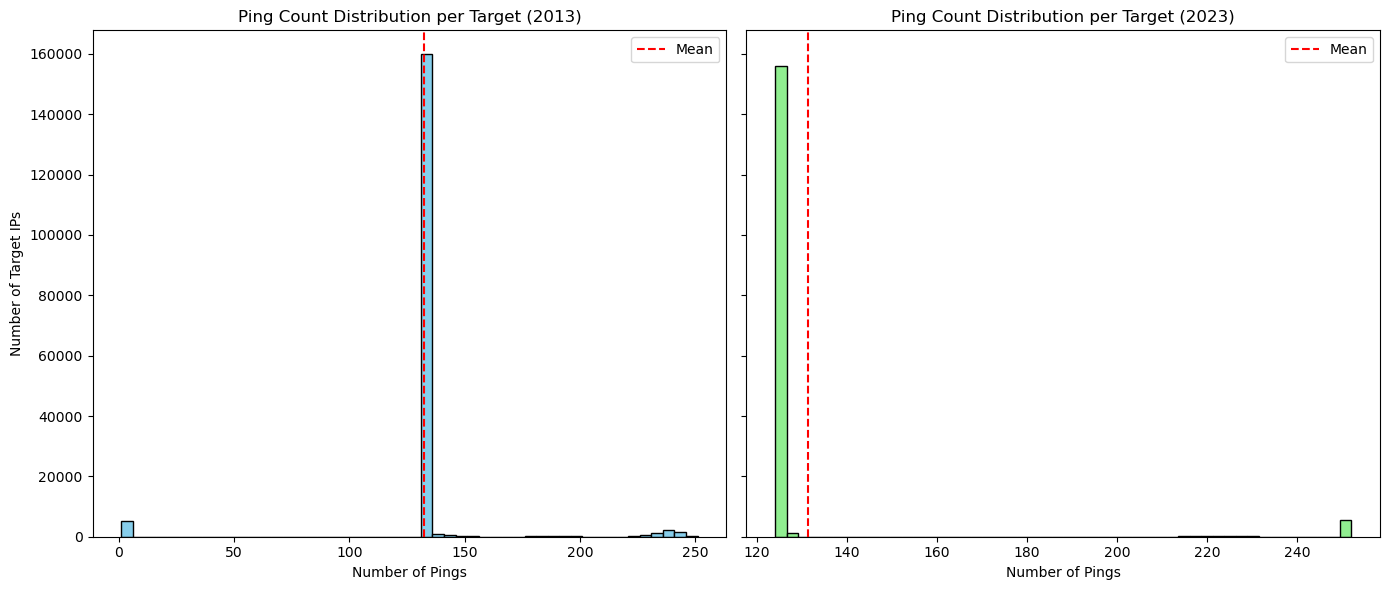

In [9]:
import matplotlib.pyplot as plt

pings_2013 = (
    df2013
    .drop_duplicates(subset=['probe_addr_2013', 'time_s_2013'])
    .groupby('probe_addr_2013')
    .size()
    .rename('ping_count')
    .reset_index()
)

pings_2023 = (
    df2023
    .drop_duplicates(subset=['probe_addr_2023', 'time_s_2023'])
    .groupby('probe_addr_2023')
    .size()
    .rename('ping_count')
    .reset_index()
)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# 2013
axes[0].hist(pings_2013['ping_count'], bins=50, color='skyblue', edgecolor='black')
axes[0].axvline(pings_2013['ping_count'].mean(), color='red', linestyle='--', label='Mean')
axes[0].set_title('Ping Count Distribution per Target (2013)')
axes[0].set_xlabel('Number of Pings')
axes[0].set_ylabel('Number of Target IPs')
axes[0].legend()

# 2023
axes[1].hist(pings_2023['ping_count'], bins=50, color='lightgreen', edgecolor='black')
axes[1].axvline(pings_2023['ping_count'].mean(), color='red', linestyle='--', label='Mean')
axes[1].set_title('Ping Count Distribution per Target (2023)')
axes[1].set_xlabel('Number of Pings')
axes[1].legend()

plt.tight_layout()
plt.show()

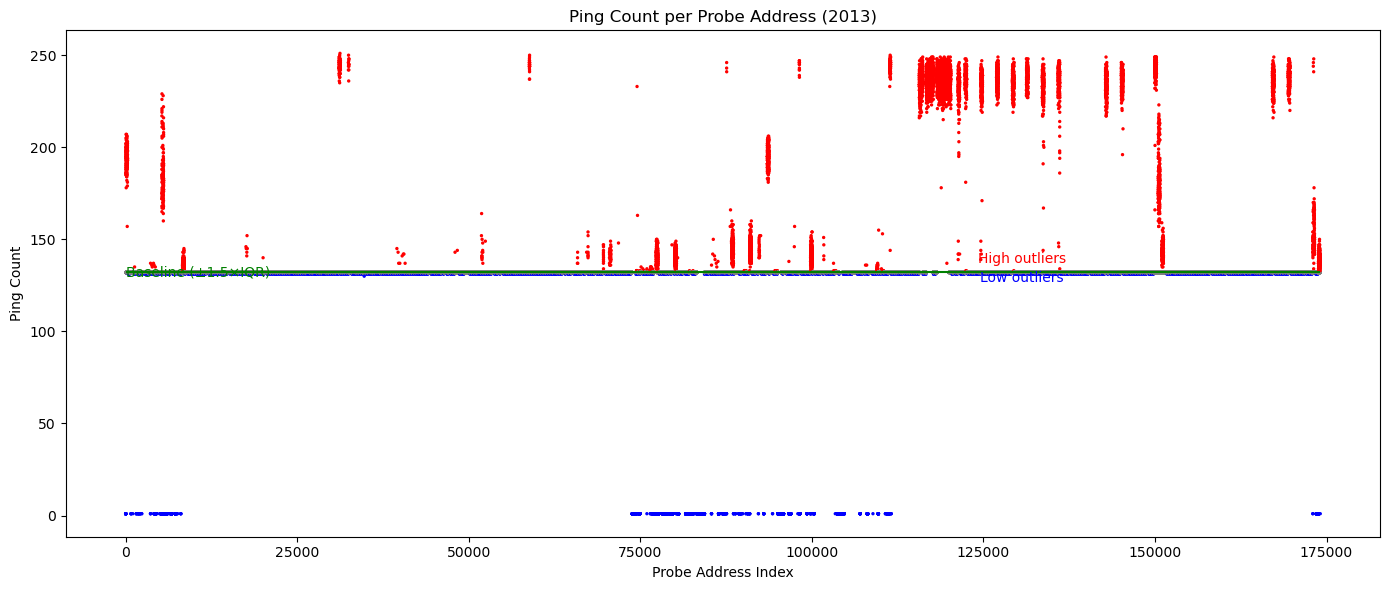

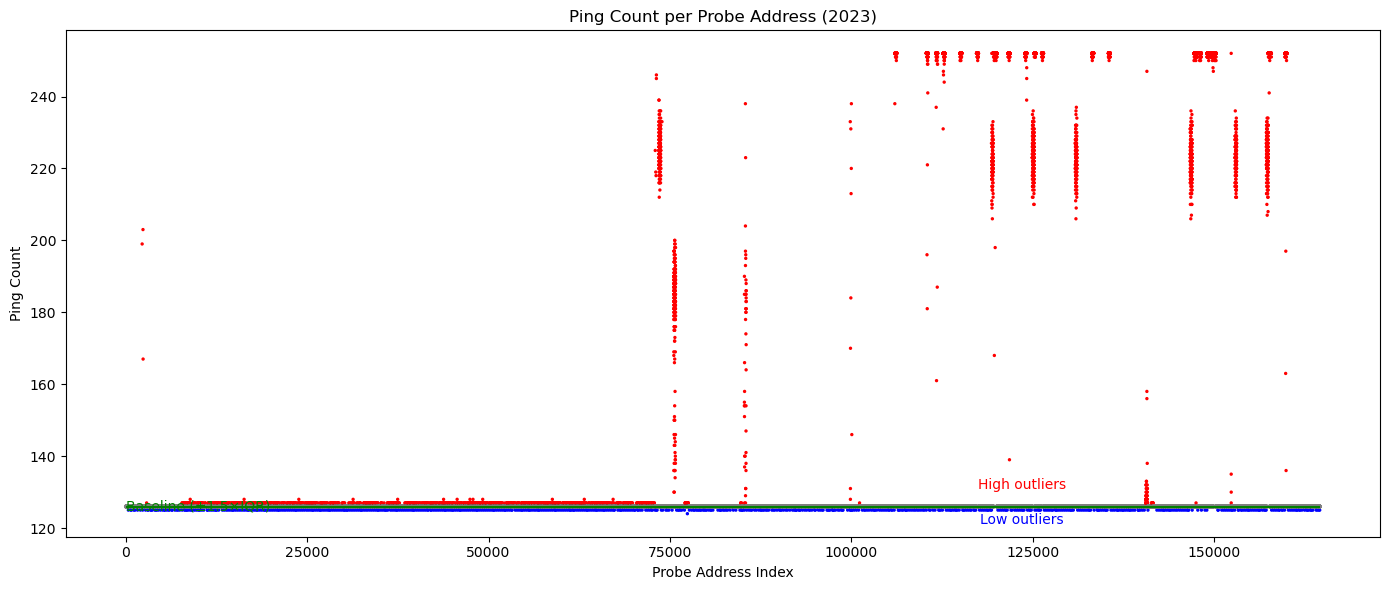

In [10]:
def compute_pings(df, probe_col, time_col):
    return (
        df
        .drop_duplicates(subset=[probe_col, time_col])
        .groupby(probe_col)
        .size()
        .rename('ping_count')
        .reset_index()
    )

def plot_ping_counts(pings_df, year):
    # 1) Compute band
    med = pings_df['ping_count'].median()
    q1, q3 = pings_df['ping_count'].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = med - 1.5 * iqr, med + 1.5 * iqr

    # 2) Color assignment
    def pick_color(x):
        if x > upper: return 'red'
        if x < lower: return 'blue'
        return 'gray'
    colors = pings_df['ping_count'].map(pick_color)

    # 3) Plot
    fig, ax = plt.subplots(figsize=(14, 6))
    x = range(len(pings_df))
    ax.scatter(x, pings_df['ping_count'], c=colors, s=2)

    # 4) Baseline box
    band = patches.Rectangle(
        (0, lower),           # bottom-left corner
        len(pings_df),        # width spans all points
        upper - lower,        # height of the band
        edgecolor='green',
        facecolor='none',
        linewidth=1.5
    )
    ax.add_patch(band)

    # 5) Annotations
    ax.text(10, med, 'Baseline (±1.5×IQR)', color='green', va='center')
    ax.text(len(pings_df)*0.75, upper + 5, 'High outliers', color='red', ha='center')
    ax.text(len(pings_df)*0.75, lower - 5, 'Low outliers', color='blue', ha='center')

    # 6) Labels & title
    ax.set_title(f'Ping Count per Probe Address ({year})')
    ax.set_xlabel('Probe Address Index')
    ax.set_ylabel('Ping Count')
    plt.tight_layout()
    plt.show()

pings_2013 = compute_pings(df2013, 'probe_addr_2013', 'time_s_2013')
pings_2023 = compute_pings(df2023, 'probe_addr_2023', 'time_s_2023')

plot_ping_counts(pings_2013, 2013)
plot_ping_counts(pings_2023, 2023)

In [11]:
def compute_probe_metrics(df, ts_col, probe_col, label_col, rtt_col):
    df = df.copy()
    df[ts_col] = pd.to_datetime(df[ts_col])
    rows = []
    for ip, grp in df.groupby(probe_col):
        g = grp.sort_values(ts_col)
        up = (g[label_col] == 'responsive').astype(int).values
        times = g[ts_col].values

        # 1) Availability = fraction of probes with an echo‑reply
        availability = up.mean()

        # 2) Volatility = count of up↔down transitions
        volatility = np.sum(np.abs(np.diff(up)))

        # 3) Find contiguous “up” runs to get their durations
        runs, start = [], 0
        for i in range(1, len(up)):
            if up[i] != up[i-1]:
                runs.append((start, i-1))
                start = i
        runs.append((start, len(up)-1))
        durations = [
            (times[e] - times[s]) / np.timedelta64(1, 's')
            for s, e in runs if up[s] == 1
        ]
        median_uptime = float(np.median(durations)) if durations else 0.0

        # 4) RTT stats over only the “responsive” probes
        pos = g.loc[g[label_col] == 'responsive', rtt_col]
        rtt_median = float(pos.median()) if len(pos) >= 1 else np.nan
        rtt_std    = float(pos.std())    if len(pos) >= 2 else np.nan

        rows.append({
            'probe_ip':      ip,
            'availability':  availability,
            'volatility':    volatility,
            'median_uptime': median_uptime,
            'rtt_median':    rtt_median,
            'rtt_std':       rtt_std
        })
    return pd.DataFrame(rows)

In [12]:
probe_metrics_2013 = compute_probe_metrics(
    df2013,
    ts_col    = 'real_time_2013',
    probe_col = 'probe_addr_2013',
    label_col = 'reply_type_label_2013',
    rtt_col   = 'rtt_ms_2013'
)
probe_metrics_2013

,probe_ip,availability,volatility,median_uptime,rtt_median,rtt_std
0,128.0.63.180,0.0,0,0.0,NaN,NaN
1,128.0.63.212,0.0,0,0.0,NaN,NaN
2,128.0.63.4,0.0,0,0.0,NaN,NaN
3,128.0.63.52,0.0,0,0.0,NaN,NaN
4,128.0.90.17,0.0,0,0.0,NaN,NaN
...,...,...,...,...,...,...
174079,128.97.77.96,0.0,0,0.0,NaN,NaN
174080,128.97.77.97,0.0,0,0.0,NaN,NaN
174081,128.97.77.98,0.0,0,0.0,NaN,NaN
174082,128.97.77.99,0.0,0,0.0,NaN,NaN


In [13]:
probe_metrics_2023 = compute_probe_metrics(
    df2023,
    ts_col    = 'real_time_2023',
    probe_col = 'probe_addr_2023',
    label_col = 'reply_type_label_2023',
    rtt_col   = 'rtt_ms_2023'
)
probe_metrics_2023

,probe_ip,availability,volatility,median_uptime,rtt_median,rtt_std
0,128.10.25.0,0.000000,0,0.0,NaN,NaN
1,128.10.25.1,0.992063,2,46530.0,61.521,49.721354
2,128.10.25.10,0.000000,0,0.0,NaN,NaN
3,128.10.25.100,1.000000,0,94380.0,60.332,30.053143
4,128.10.25.101,0.992063,2,46530.0,60.320,49.928804
...,...,...,...,...,...,...
164601,128.97.190.95,0.000000,0,0.0,NaN,NaN
164602,128.97.190.96,0.000000,0,0.0,NaN,NaN
164603,128.97.190.97,0.000000,0,0.0,NaN,NaN
164604,128.97.190.98,0.000000,0,0.0,NaN,NaN


In [14]:
# 1) Summary of each metric
print("Availability:\n", probe_metrics_2013['availability'].describe(), "\n")
print("Volatility:\n", probe_metrics_2013['volatility'].describe(), "\n")
print("Median uptime:\n", probe_metrics_2013['median_uptime'].describe(), "\n")
print("RTT median:\n", probe_metrics_2013['rtt_median'].describe(), "\n")
print("RTT std:\n", probe_metrics_2013['rtt_std'].describe(), "\n")

# 2) How many IPs ever got a response?
num_up = (probe_metrics_2013['availability'] > 0).sum()
print(f"IPs with availability > 0: {num_up} out of {len(probe_metrics_2013)}")

# 3) Show the top responders
print("\nTop 10 IPs by availability:")
display(probe_metrics_2013.sort_values('availability', ascending=False).head(10))

print("\nTop 10 IPs by volatility:")
display(probe_metrics_2013.sort_values('volatility', ascending=False).head(10))

Availability:
 count    174084.000000
mean          0.059715
std           0.199851
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.900000
Name: availability, dtype: float64 

Volatility:
 count    174084.000000
mean          2.516394
std           8.549438
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         191.000000
Name: volatility, dtype: float64 

Median uptime:
 count    174084.000000
mean        196.967119
std         750.522779
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       17821.000000
Name: median_uptime, dtype: float64 

RTT median:
 count    15510.000000
mean       302.203938
std        133.781575
min         73.767000
25%        246.432375
50%        274.003750
75%        318.015750
max       2460.771000
Name: rtt_median, dtype: float64 

RTT std:
 count    15409.000000
mean       472.017240
std        102.8

,probe_ip,availability,volatility,median_uptime,rtt_median,rtt_std
16462,128.125.125.76,0.900000,24,1981.0,269.4940,448.520400
106229,128.54.69.67,0.900000,20,2640.0,292.2385,558.349786
17635,128.125.13.209,0.895397,21,5940.0,269.6815,440.941646
106225,128.54.69.63,0.895397,24,1981.0,289.3370,446.937379
18672,128.125.133.220,0.890756,25,3961.0,246.8485,387.970359
29839,128.125.174.133,0.890756,23,3300.5,240.6555,317.547478
106216,128.54.69.55,0.890756,27,2639.5,258.5750,409.189630
26903,128.125.163.26,0.888889,17,9240.0,209.1290,487.930689
106234,128.54.69.71,0.881356,30,1320.0,253.4930,407.145745
60207,128.125.50.48,0.880342,28,1980.0,301.4175,562.906928



Top 10 IPs by volatility:


,probe_ip,availability,volatility,median_uptime,rtt_median,rtt_std
52062,128.125.251.90,0.293478,191,0.0,244.3385,483.522442
167234,128.9.64.212,0.394309,171,0.0,234.4550,520.344414
111530,128.84.154.8,0.440171,169,0.0,298.6440,429.807497
33197,128.125.186.160,0.484848,90,0.0,250.8395,432.800934
50945,128.125.248.236,0.431818,88,0.0,254.9660,300.586120
70476,128.125.87.74,0.522727,83,0.0,281.6200,449.040788
89766,128.2.113.219,0.507576,77,0.0,334.0690,465.278695
49671,128.125.243.241,0.340909,72,0.0,342.9640,352.334184
16632,128.125.126.228,0.537879,72,0.0,386.0430,557.660142
10286,128.125.103.47,0.560606,69,660.0,251.1760,463.604514


In [15]:
# 1) Summary of each metric
print("Availability:\n", probe_metrics_2023['availability'].describe(), "\n")
print("Volatility:\n", probe_metrics_2023['volatility'].describe(), "\n")
print("Median uptime:\n", probe_metrics_2023['median_uptime'].describe(), "\n")
print("RTT median:\n", probe_metrics_2023['rtt_median'].describe(), "\n")
print("RTT std:\n", probe_metrics_2023['rtt_std'].describe(), "\n")

# 2) How many IPs ever got a response?
num_up_23 = (probe_metrics_2013['availability'] > 0).sum()
print(f"IPs with availability > 0: {num_up_23} out of {len(probe_metrics_2023)}")

# 3) Show the top responders
print("\nTop 10 IPs by availability:")
display(probe_metrics_2023.sort_values('availability', ascending=False).head(10))

print("\nTop 10 IPs by volatility:")
display(probe_metrics_2023.sort_values('volatility', ascending=False).head(10))

Availability:
 count    164606.000000
mean          0.027415
std           0.160994
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: availability, dtype: float64 

Volatility:
 count    164606.000000
mean          0.134248
std           2.101220
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         213.000000
Name: volatility, dtype: float64 

Median uptime:
 count    164606.000000
mean       1800.186169
std       12139.470808
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       94382.000000
Name: median_uptime, dtype: float64 

RTT median:
 count    4795.000000
mean      125.360999
std        93.369317
min         0.161500
25%        60.351000
50%       146.326500
75%       179.330500
max      1123.289000
Name: rtt_median, dtype: float64 

RTT std:
 count    4779.000000
mean       46.835587
std        43.806134
min  

,probe_ip,availability,volatility,median_uptime,rtt_median,rtt_std
97841,128.54.69.142,1.0,0,94380.0,4.2335,8.372307
73922,128.134.87.43,1.0,0,94380.0,147.3300,40.572271
73919,128.134.87.40,1.0,0,94380.0,156.4835,67.812229
73918,128.134.87.4,1.0,0,94380.0,145.5260,39.100701
81364,128.176.234.6,1.0,0,94380.0,172.1085,54.453978
73916,128.134.87.38,1.0,0,94380.0,145.3885,48.021751
73914,128.134.87.36,1.0,0,94380.0,144.7445,51.102026
5519,128.119.110.227,1.0,0,94380.0,74.9570,40.400573
5518,128.119.110.226,1.0,0,94380.0,72.6605,46.890687
5517,128.119.110.225,1.0,0,94380.0,72.5830,50.843782



Top 10 IPs by volatility:


,probe_ip,availability,volatility,median_uptime,rtt_median,rtt_std
124127,128.9.176.7,0.179743,213,0.0,2.1535,30.031088
147200,128.9.28.1,0.397476,211,0.0,0.2075,7.301462
147489,128.9.29.129,0.332454,197,0.0,0.1905,14.144226
83953,128.2.113.86,0.380952,66,0.0,77.5185,42.583581
101144,128.79.85.12,0.571429,60,660.0,309.5230,50.117506
101279,128.79.85.241,0.492063,59,660.0,309.4450,164.452466
101364,128.79.85.89,0.539683,59,660.0,305.7060,51.754565
101244,128.79.85.21,0.611111,58,329.5,309.4320,58.982256
101346,128.79.85.72,0.587302,57,660.0,309.4880,70.113316
101125,128.79.85.102,0.539683,56,660.0,309.6385,61.177558


In [16]:
probe_metrics_2013['block24'] = probe_metrics_2013['probe_ip']\
    .apply(lambda ip: f"{ipaddress.ip_network(ip+'/24', strict=False).network_address}/24")
probe_metrics_2023['block24'] = probe_metrics_2023['probe_ip']\
    .apply(lambda ip: f"{ipaddress.ip_network(ip+'/24', strict=False).network_address}/24")

agg_funcs = {
    'availability': ['median','mean'],
    'volatility':   ['median','mean'],
    'median_uptime':['median','mean'],
    'rtt_median':   ['median','mean'],
    'rtt_std':      ['median','mean'],
}

block_stats_2013 = (
    probe_metrics_2013
      .groupby('block24')
      .agg(agg_funcs)
)
block_stats_2013.columns = [
    f"{metric}_{stat}"
    for metric, stat in block_stats_2013.columns
]
block_stats_2013 = block_stats_2013.reset_index()

block_stats_2023 = (
    probe_metrics_2023
      .groupby('block24')
      .agg(agg_funcs)
)
block_stats_2023.columns = [
    f"{metric}_{stat}"
    for metric, stat in block_stats_2023.columns
]
block_stats_2023 = block_stats_2023.reset_index()

In [17]:
print("2013 block stats (median & mean):")
display(block_stats_2013)

2013 block stats (median & mean):


,block24,availability_median,availability_mean,volatility_median,volatility_mean,median_uptime_median,median_uptime_mean,rtt_median_median,rtt_median_mean,rtt_std_median,rtt_std_mean
0,128.0.63.0/24,0.0,0.000000,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN
1,128.0.90.0/24,0.0,0.000000,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN
2,128.0.94.0/24,0.0,0.000000,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN
3,128.10.25.0/24,0.0,0.208777,0.0,8.132812,0.0,629.064453,306.26100,307.754007,479.754063,480.700850
4,128.100.210.0/24,0.0,0.023793,0.0,0.875000,0.0,74.761719,294.47925,326.523312,437.262620,475.702708
...,...,...,...,...,...,...,...,...,...,...,...
1584,128.97.245.0/24,0.0,0.000000,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN
1585,128.97.247.0/24,0.0,0.000000,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN
1586,128.97.248.0/24,0.0,0.000000,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN
1587,128.97.77.0/24,0.0,0.005771,0.0,0.265625,0.0,9.023438,261.23350,261.233500,455.493200,455.493200


In [18]:
print("2023 block stats (median & mean):")
display(block_stats_2023)

2023 block stats (median & mean):


,block24,availability_median,availability_mean,volatility_median,volatility_mean,median_uptime_median,median_uptime_mean,rtt_median_median,rtt_median_mean,rtt_std_median,rtt_std_mean
0,128.10.25.0/24,0.0,0.311973,0.0,0.132812,0.0,26566.285156,60.53175,60.513031,41.621361,41.029831
1,128.100.210.0/24,0.0,0.003906,0.0,0.000000,0.0,368.671875,84.07150,84.071500,48.858830,48.858830
2,128.100.56.0/24,0.0,0.007812,0.0,0.000000,0.0,737.343750,84.22150,84.221500,59.344172,59.344172
3,128.100.98.0/24,0.0,0.000000,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN
4,128.101.161.0/24,0.0,0.028243,0.0,0.023438,0.0,2465.976562,52.95200,52.996167,24.447603,31.624917
...,...,...,...,...,...,...,...,...,...,...,...
638,128.90.181.0/24,0.0,0.054005,0.0,0.250000,0.0,4921.636719,265.62825,270.865138,59.698974,190.789496
639,128.90.76.0/24,0.0,0.000000,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN
640,128.93.27.0/24,0.0,0.003906,0.0,0.000000,0.0,368.671875,153.61850,153.618500,43.087952,43.087952
641,128.95.249.0/24,0.0,0.027313,0.0,0.007812,0.0,2393.789062,27.78050,27.875143,23.782756,20.102394


In [19]:
assert probe_metrics_2013['block24'].nunique() == len(block_stats_2013), \
       "Mismatch in number of /24s!"
print(f"{len(block_stats_2013)} blocks in 2013, {len(block_stats_2023)} blocks in 2023")

1589 blocks in 2013, 643 blocks in 2023


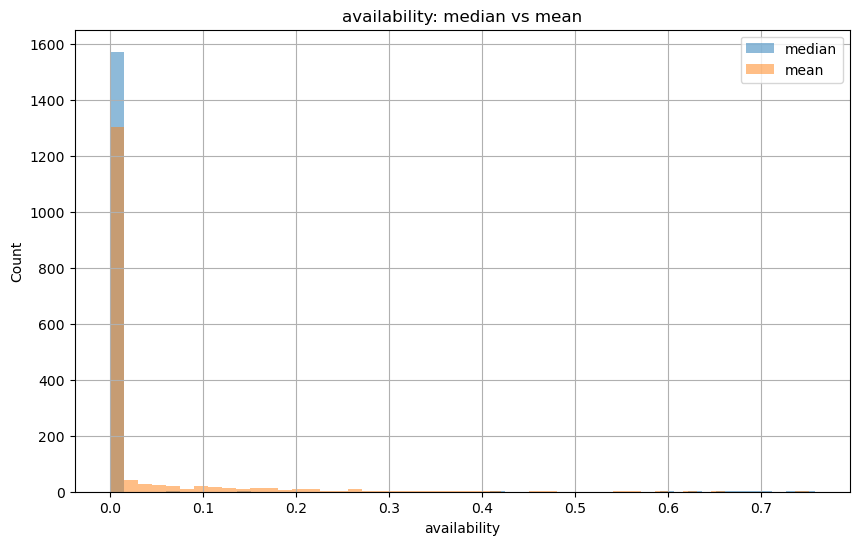

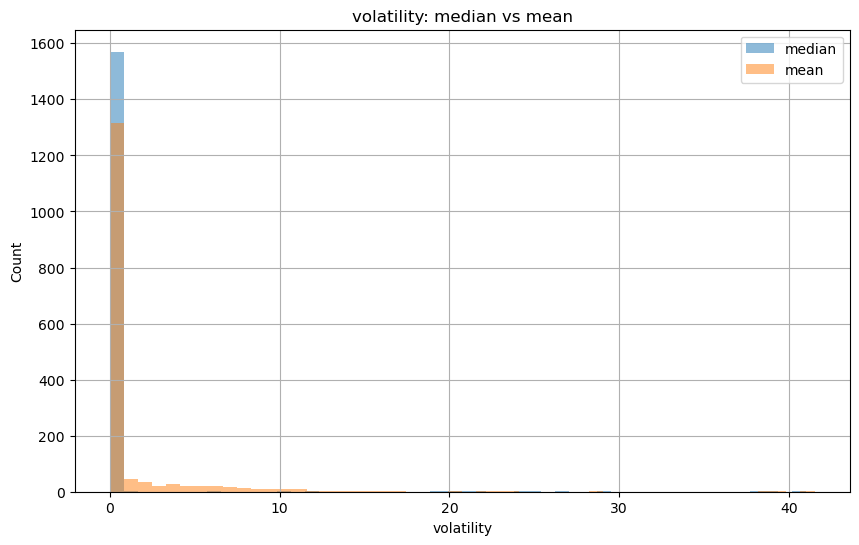

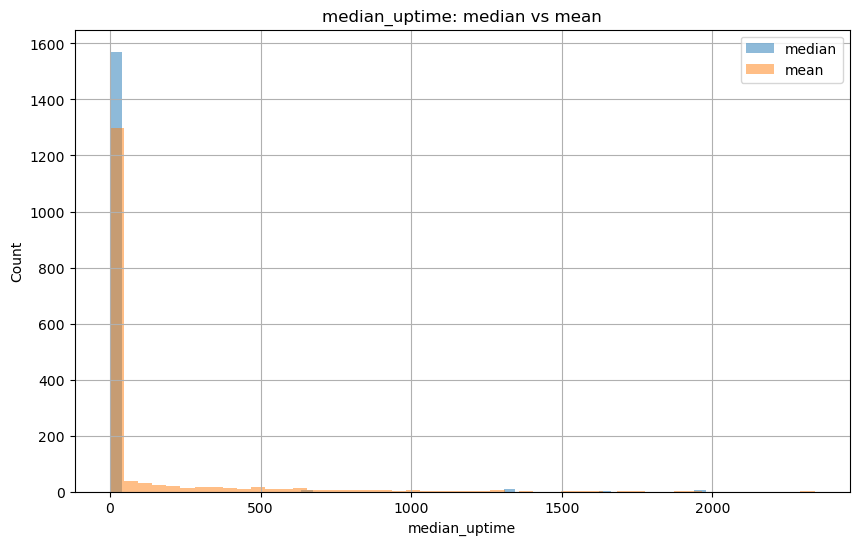

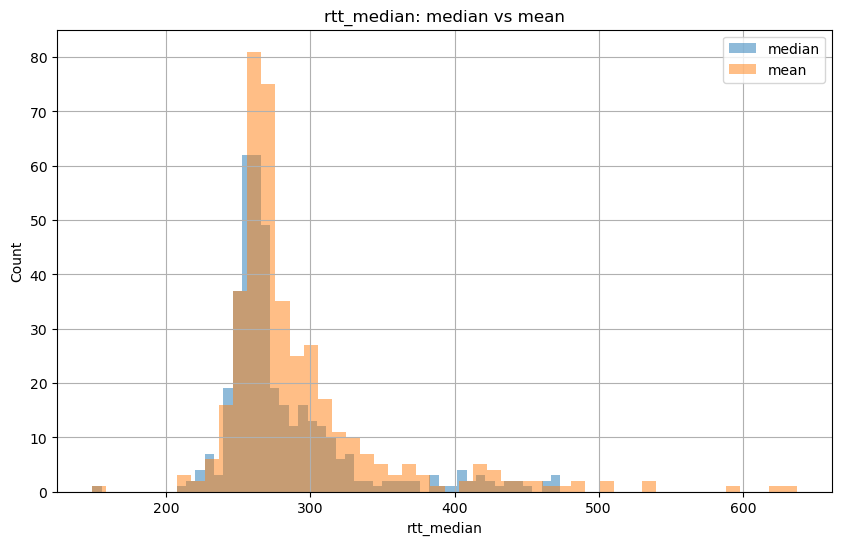

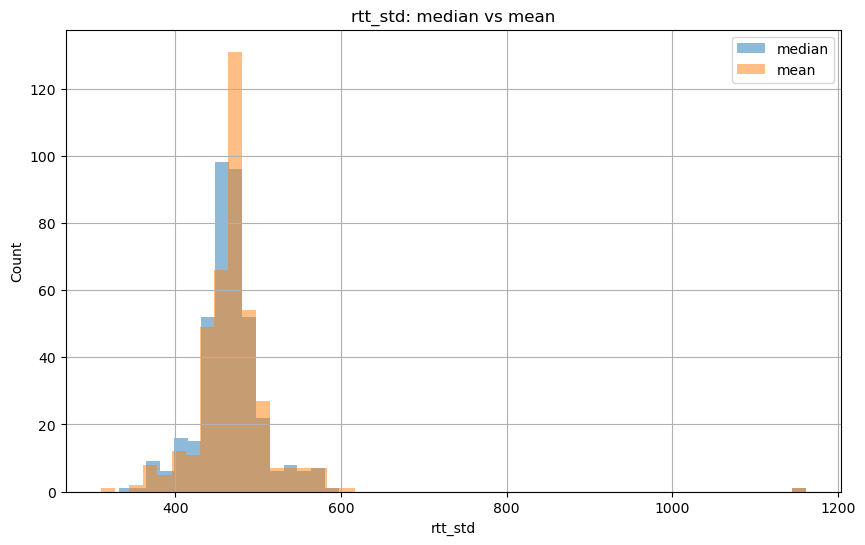

In [20]:
metrics = ['availability','volatility','median_uptime','rtt_median','rtt_std']
for m in metrics:
    plt.figure()
    block_stats_2013[f'{m}_median'].dropna().hist(bins=50, alpha=0.5, label='median')
    block_stats_2013[f'{m}_mean'].dropna().hist(bins=50, alpha=0.5, label='mean')
    plt.legend(); plt.title(f'{m}: median vs mean'); plt.xlabel(m); plt.ylabel('Count')
    plt.show()

In [21]:
pings_pp_2013 = int(df2013['probe_addr_2013'].value_counts().median())  # ≈132
pings_pp_2023 = int(df2023['probe_addr_2023'].value_counts().median())  # ≈126

for bs, ppp in [
    (block_stats_2013, pings_pp_2013),
    (block_stats_2023, pings_pp_2023),
]:
    bs['volatility_median_norm'] = bs['volatility_median'] / ppp
    bs['volatility_mean_norm']   = bs['volatility_mean']   / ppp

# ── Recompute responder counts per /24 ──
for year, pm in [('2013', probe_metrics_2013), ('2023', probe_metrics_2023)]:
    resps = (
        pm
        .groupby('block24')['availability']
        .apply(lambda a: (a > 0).sum())
        .rename('n_responders')
        .reset_index()
    )
    globals()[f"resps_{year}"] = resps

# ── Strict Cai 3.4 classifier ──
alphaH, alphaL, beta, gamma = 0.95, 0.10, 0.0016, 6*3600
MIN_RESP = 0.2*256

def cai_cat_strict(r):
    if r.n_responders < MIN_RESP:
        return 'unclassifiable'
    A, V, U = r.availability, r.volatility_norm, r.median_uptime
    if A >= alphaH and V <= beta:
        return 'always‑stable'
    if U >= gamma and A >= alphaL and (A < alphaH or V > beta):
        return 'sometimes‑stable'
    if U <  gamma and A >= alphaL and (A < alphaH or V > beta):
        return 'intermittent'
    if A < alphaL:
        return 'underutilized'
    return 'unclassifiable'

for year, bs, resps in [
    ('2013', block_stats_2013, resps_2013),
    ('2023', block_stats_2023, resps_2023),
]:
    print(f"\n=== Year {year} (strict Cai §3.4, normalized volatility) ===")
    for mode in ['median', 'mean']:
        sub = bs[[
            'block24',
            f'availability_{mode}',
            f'volatility_{mode}_norm',
            f'median_uptime_{mode}'
        ]].copy()
        sub.columns = ['block24','availability','volatility_norm','median_uptime']
        sub = sub.merge(resps, on='block24', how='left')

        cat_col = f'cai_{mode}_category_{year}_strict'
        sub[cat_col] = sub.apply(cai_cat_strict, axis=1)

        varname = f"cai_{mode}_cls_{year}_strict"
        globals()[varname] = sub

        print(f"\n» {mode.title()}‑based ({len(sub)} blocks):")
        print(sub[cat_col].value_counts())


=== Year 2013 (strict Cai §3.4, normalized volatility) ===

» Median‑based (1589 blocks):
cai_median_category_2013_strict
unclassifiable    1480
underutilized       92
intermittent        17
Name: count, dtype: int64

» Mean‑based (1589 blocks):
cai_mean_category_2013_strict
unclassifiable    1480
intermittent       107
underutilized        2
Name: count, dtype: int64

=== Year 2023 (strict Cai §3.4, normalized volatility) ===

» Median‑based (643 blocks):
cai_median_category_2023_strict
unclassifiable      618
underutilized        12
always‑stable         7
intermittent          4
sometimes‑stable      2
Name: count, dtype: int64

» Mean‑based (643 blocks):
cai_mean_category_2023_strict
unclassifiable      618
sometimes‑stable     18
intermittent          7
Name: count, dtype: int64


In [22]:
cai_mean_cls_2013_strict = globals()['cai_mean_cls_2013_strict']
cai_mean_cls_2023_strict = globals()['cai_mean_cls_2023_strict']

In [23]:
cai_mean_cls_2013_strict

,block24,availability,volatility_norm,median_uptime,n_responders,cai_mean_category_2013_strict
0,128.0.63.0/24,0.000000,0.000000,0.000000,0,unclassifiable
1,128.0.90.0/24,0.000000,0.000000,0.000000,0,unclassifiable
2,128.0.94.0/24,0.000000,0.000000,0.000000,0,unclassifiable
3,128.10.25.0/24,0.208777,0.061612,629.064453,71,intermittent
4,128.100.210.0/24,0.023793,0.006629,74.761719,8,unclassifiable
...,...,...,...,...,...,...
1584,128.97.245.0/24,0.000000,0.000000,0.000000,0,unclassifiable
1585,128.97.247.0/24,0.000000,0.000000,0.000000,0,unclassifiable
1586,128.97.248.0/24,0.000000,0.000000,0.000000,0,unclassifiable
1587,128.97.77.0/24,0.005771,0.002012,9.023438,2,unclassifiable


In [24]:
cai_mean_cls_2023_strict

,block24,availability,volatility_norm,median_uptime,n_responders,cai_mean_category_2023_strict
0,128.10.25.0/24,0.311973,0.001054,26566.285156,80,sometimes‑stable
1,128.100.210.0/24,0.003906,0.000000,368.671875,1,unclassifiable
2,128.100.56.0/24,0.007812,0.000000,737.343750,2,unclassifiable
3,128.100.98.0/24,0.000000,0.000000,0.000000,0,unclassifiable
4,128.101.161.0/24,0.028243,0.000186,2465.976562,9,unclassifiable
...,...,...,...,...,...,...
638,128.90.181.0/24,0.054005,0.001984,4921.636719,40,unclassifiable
639,128.90.76.0/24,0.000000,0.000000,0.000000,0,unclassifiable
640,128.93.27.0/24,0.003906,0.000000,368.671875,1,unclassifiable
641,128.95.249.0/24,0.027313,0.000062,2393.789062,7,unclassifiable


In [25]:
def classify_blocks_ml_3d(
    blocks_df,
    avail_col,
    rtt_col,
    rtt_std_col,
    inactive_thresh=0.1,
    rtt_split_quantile=0.5,
    n_clusters=4
):
    df = blocks_df[['block24', avail_col, rtt_col, rtt_std_col]].copy()
    df.columns = ['block24', 'availability', 'median_RTT', 'rtt_std']

    # 1) Mark inactive blocks
    inactive = df[df['availability'] < inactive_thresh].copy()
    inactive['category'] = 'inactive'

    # 2) Active blocks for clustering
    active = df[
        (df['availability'] >= inactive_thresh) &
        df[['median_RTT', 'rtt_std']].notna().all(axis=1)
    ].copy()

    X = active[['availability', 'median_RTT', 'rtt_std']].values
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)
    km = KMeans(n_clusters=n_clusters, random_state=42).fit(Xs)
    active['cluster_id'] = km.labels_

    # 3) Add this to evaluate clustering quality
    score = silhouette_score(Xs, km.labels_)
    print(f"Silhouette score: {score:.3f}")

    # 4) Inverse scale centers for interpretation
    centers = pd.DataFrame(
        scaler.inverse_transform(km.cluster_centers_),
        columns=['availability', 'median_RTT', 'rtt_std']
    )

    # 5) Semantic labeling
    order = centers['availability'].sort_values(ascending=False).index
    mapping = {
        order[0]: 'always‑active',
        order[-1]: 'underutilized'
    }

    split_val = active['rtt_std'].quantile(rtt_split_quantile)
    for idx in order[1:-1]:
        mapping[idx] = (
            'intermittent'
            if centers.loc[idx, 'rtt_std'] >= split_val
            else 'sometimes‑active'
        )

    active['category'] = active['cluster_id'].map(mapping)

    return pd.concat([
        active[['block24', 'category']],
        inactive[['block24', 'category']]
    ], ignore_index=True)

In [26]:
inactive_thresholds = [0.01, 0.05, 0.10, 0.15, 0.20]
rtt_split_quantiles = [0.25, 0.50, 0.75]

for inactive_thresh in inactive_thresholds:
    for rtt_q in rtt_split_quantiles:
        print(f"\n=== ML (3D) sweep: inactive_thresh={inactive_thresh:.2f}, rtt_q={rtt_q:.2f} ===")
        for year, bs in [('2013', block_stats_2013), ('2023', block_stats_2023)]:
            for stat in ['median', 'mean']:
                result = classify_blocks_ml_3d(
                    bs,
                    avail_col=f'availability_{stat}',
                    rtt_col=f'rtt_median_{stat}',
                    rtt_std_col=f'rtt_std_{stat}',
                    inactive_thresh=inactive_thresh,
                    rtt_split_quantile=rtt_q
                )
                print(f"  ML‑3D‑{stat}‑{year}:", result['category'].value_counts().to_dict())


=== ML (3D) sweep: inactive_thresh=0.01, rtt_q=0.25 ===
Silhouette score: 0.375
  ML‑3D‑median‑2013: {'inactive': 1571, 'always‑active': 10, 'intermittent': 6, 'underutilized': 2}
Silhouette score: 0.342
  ML‑3D‑mean‑2013: {'inactive': 1284, 'intermittent': 197, 'underutilized': 58, 'always‑active': 50}
Silhouette score: 0.644
  ML‑3D‑median‑2023: {'inactive': 630, 'intermittent': 9, 'always‑active': 3, 'underutilized': 1}
Silhouette score: 0.497
  ML‑3D‑mean‑2023: {'inactive': 549, 'intermittent': 44, 'sometimes‑active': 31, 'always‑active': 18, 'underutilized': 1}

=== ML (3D) sweep: inactive_thresh=0.01, rtt_q=0.50 ===
Silhouette score: 0.375
  ML‑3D‑median‑2013: {'inactive': 1571, 'always‑active': 10, 'intermittent': 5, 'underutilized': 2, 'sometimes‑active': 1}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

Silhouette score: 0.342
  ML‑3D‑mean‑2013: {'inactive': 1284, 'intermittent': 197, 'underutilized': 58, 'always‑active': 50}
Silhouette score: 0.644
  ML‑3D‑median‑2023: {'inactive': 630, 'intermittent': 8, 'always‑active': 3, 'sometimes‑active': 1, 'underutilized': 1}
Silhouette score: 0.497
  ML‑3D‑mean‑2023: {'inactive': 549, 'intermittent': 44, 'sometimes‑active': 31, 'always‑active': 18, 'underutilized': 1}

=== ML (3D) sweep: inactive_thresh=0.01, rtt_q=0.75 ===
Silhouette score: 0.375
  ML‑3D‑median‑2013: {'inactive': 1571, 'always‑active': 10, 'intermittent': 5, 'underutilized': 2, 'sometimes‑active': 1}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score: 0.342
  ML‑3D‑mean‑2013: {'inactive': 1284, 'sometimes‑active': 174, 'underutilized': 58, 'always‑active': 50, 'intermittent': 23}
Silhouette score: 0.644
  ML‑3D‑median‑2023: {'inactive': 630, 'sometimes‑active': 9, 'always‑active': 3, 'underutilized': 1}
Silhouette score: 0.497
  ML‑3D‑mean‑2023: {'inactive': 549, 'sometimes‑active': 75, 'always‑active': 18, 'underutilized': 1}

=== ML (3D) sweep: inactive_thresh=0.05, rtt_q=0.25 ===
Silhouette score: 0.375
  ML‑3D‑median‑2013: {'inactive': 1571, 'always‑active': 10, 'intermittent': 6, 'underutilized': 2}
Silhouette score: 0.324
  ML‑3D‑mean‑2013: {'inactive': 1373, 'sometimes‑active': 94, 'underutilized': 85, 'always‑active': 21, 'intermittent': 16}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

Silhouette score: 0.644
  ML‑3D‑median‑2023: {'inactive': 630, 'intermittent': 9, 'always‑active': 3, 'underutilized': 1}
Silhouette score: 0.517
  ML‑3D‑mean‑2023: {'inactive': 591, 'intermittent': 41, 'always‑active': 10, 'underutilized': 1}

=== ML (3D) sweep: inactive_thresh=0.05, rtt_q=0.50 ===
Silhouette score: 0.375
  ML‑3D‑median‑2013: {'inactive': 1571, 'always‑active': 10, 'intermittent': 5, 'underutilized': 2, 'sometimes‑active': 1}
Silhouette score: 0.324
  ML‑3D‑mean‑2013: {'inactive': 1373, 'sometimes‑active': 94, 'underutilized': 85, 'always‑active': 21, 'intermittent': 16}
Silhouette score: 0.644
  ML‑3D‑median‑2023: {'inactive': 630, 'intermittent': 8, 'always‑active': 3, 'sometimes‑active': 1, 'underutilized': 1}
Silhouette score: 0.517
  ML‑3D‑mean‑2023: {'inactive': 591, 'sometimes‑active': 32, 'always‑active': 10, 'intermittent': 9, 'underutilized': 1}

=== ML (3D) sweep: inactive_thresh=0.05, rtt_q=0.75 ===


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

Silhouette score: 0.375
  ML‑3D‑median‑2013: {'inactive': 1571, 'always‑active': 10, 'intermittent': 5, 'underutilized': 2, 'sometimes‑active': 1}
Silhouette score: 0.324
  ML‑3D‑mean‑2013: {'inactive': 1373, 'sometimes‑active': 94, 'underutilized': 85, 'always‑active': 21, 'intermittent': 16}
Silhouette score: 0.644
  ML‑3D‑median‑2023: {'inactive': 630, 'sometimes‑active': 9, 'always‑active': 3, 'underutilized': 1}
Silhouette score: 0.517
  ML‑3D‑mean‑2023: {'inactive': 591, 'sometimes‑active': 32, 'always‑active': 10, 'intermittent': 9, 'underutilized': 1}

=== ML (3D) sweep: inactive_thresh=0.10, rtt_q=0.25 ===
Silhouette score: 0.275
  ML‑3D‑median‑2013: {'inactive': 1572, 'intermittent': 9, 'always‑active': 7, 'underutilized': 1}
Silhouette score: 0.422
  ML‑3D‑mean‑2013: {'inactive': 1440, 'intermittent': 127, 'always‑active': 20, 'underutilized': 2}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

Silhouette score: 0.644
  ML‑3D‑median‑2023: {'inactive': 630, 'intermittent': 9, 'always‑active': 3, 'underutilized': 1}
Silhouette score: 0.480
  ML‑3D‑mean‑2023: {'inactive': 607, 'sometimes‑active': 10, 'always‑active': 9, 'intermittent': 9, 'underutilized': 8}

=== ML (3D) sweep: inactive_thresh=0.10, rtt_q=0.50 ===
Silhouette score: 0.275
  ML‑3D‑median‑2013: {'inactive': 1572, 'intermittent': 8, 'always‑active': 7, 'underutilized': 1, 'sometimes‑active': 1}
Silhouette score: 0.422
  ML‑3D‑mean‑2013: {'inactive': 1440, 'sometimes‑active': 89, 'intermittent': 38, 'always‑active': 20, 'underutilized': 2}
Silhouette score: 0.644
  ML‑3D‑median‑2023: {'inactive': 630, 'intermittent': 8, 'always‑active': 3, 'sometimes‑active': 1, 'underutilized': 1}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

Silhouette score: 0.480
  ML‑3D‑mean‑2023: {'inactive': 607, 'sometimes‑active': 10, 'always‑active': 9, 'intermittent': 9, 'underutilized': 8}

=== ML (3D) sweep: inactive_thresh=0.10, rtt_q=0.75 ===
Silhouette score: 0.275
  ML‑3D‑median‑2013: {'inactive': 1572, 'sometimes‑active': 9, 'always‑active': 7, 'underutilized': 1}
Silhouette score: 0.422
  ML‑3D‑mean‑2013: {'inactive': 1440, 'sometimes‑active': 89, 'intermittent': 38, 'always‑active': 20, 'underutilized': 2}
Silhouette score: 0.644
  ML‑3D‑median‑2023: {'inactive': 630, 'sometimes‑active': 9, 'always‑active': 3, 'underutilized': 1}
Silhouette score: 0.480
  ML‑3D‑mean‑2023: {'inactive': 607, 'sometimes‑active': 10, 'always‑active': 9, 'intermittent': 9, 'underutilized': 8}

=== ML (3D) sweep: inactive_thresh=0.15, rtt_q=0.25 ===
Silhouette score: 0.386
  ML‑3D‑median‑2013: {'inactive': 1573, 'intermittent': 11, 'always‑active': 4, 'underutilized': 1}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

Silhouette score: 0.374
  ML‑3D‑mean‑2013: {'inactive': 1488, 'sometimes‑active': 45, 'intermittent': 35, 'always‑active': 14, 'underutilized': 7}
Silhouette score: 0.644
  ML‑3D‑median‑2023: {'inactive': 630, 'intermittent': 9, 'always‑active': 3, 'underutilized': 1}
Silhouette score: 0.502
  ML‑3D‑mean‑2023: {'inactive': 615, 'always‑active': 9, 'intermittent': 8, 'underutilized': 6, 'sometimes‑active': 5}

=== ML (3D) sweep: inactive_thresh=0.15, rtt_q=0.50 ===
Silhouette score: 0.386
  ML‑3D‑median‑2013: {'inactive': 1573, 'sometimes‑active': 10, 'always‑active': 4, 'underutilized': 1, 'intermittent': 1}
Silhouette score: 0.374
  ML‑3D‑mean‑2013: {'inactive': 1488, 'sometimes‑active': 45, 'intermittent': 35, 'always‑active': 14, 'underutilized': 7}
Silhouette score: 0.644
  ML‑3D‑median‑2023: {'inactive': 630, 'intermittent': 8, 'always‑active': 3, 'sometimes‑active': 1, 'underutilized': 1}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

Silhouette score: 0.502
  ML‑3D‑mean‑2023: {'inactive': 615, 'always‑active': 9, 'intermittent': 8, 'underutilized': 6, 'sometimes‑active': 5}

=== ML (3D) sweep: inactive_thresh=0.15, rtt_q=0.75 ===
Silhouette score: 0.386
  ML‑3D‑median‑2013: {'inactive': 1573, 'sometimes‑active': 10, 'always‑active': 4, 'underutilized': 1, 'intermittent': 1}
Silhouette score: 0.374
  ML‑3D‑mean‑2013: {'inactive': 1488, 'sometimes‑active': 45, 'intermittent': 35, 'always‑active': 14, 'underutilized': 7}
Silhouette score: 0.644
  ML‑3D‑median‑2023: {'inactive': 630, 'sometimes‑active': 9, 'always‑active': 3, 'underutilized': 1}
Silhouette score: 0.502
  ML‑3D‑mean‑2023: {'inactive': 615, 'always‑active': 9, 'intermittent': 8, 'underutilized': 6, 'sometimes‑active': 5}

=== ML (3D) sweep: inactive_thresh=0.20, rtt_q=0.25 ===


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

Silhouette score: 0.386
  ML‑3D‑median‑2013: {'inactive': 1573, 'intermittent': 11, 'always‑active': 4, 'underutilized': 1}
Silhouette score: 0.473
  ML‑3D‑mean‑2013: {'inactive': 1527, 'underutilized': 31, 'intermittent': 20, 'always‑active': 11}
Silhouette score: 0.644
  ML‑3D‑median‑2023: {'inactive': 630, 'intermittent': 9, 'always‑active': 3, 'underutilized': 1}
Silhouette score: 0.534
  ML‑3D‑mean‑2023: {'inactive': 618, 'always‑active': 9, 'intermittent': 7, 'underutilized': 5, 'sometimes‑active': 4}

=== ML (3D) sweep: inactive_thresh=0.20, rtt_q=0.50 ===
Silhouette score: 0.386
  ML‑3D‑median‑2013: {'inactive': 1573, 'sometimes‑active': 10, 'always‑active': 4, 'underutilized': 1, 'intermittent': 1}
Silhouette score: 0.473
  ML‑3D‑mean‑2013: {'inactive': 1527, 'underutilized': 31, 'intermittent': 20, 'always‑active': 11}
Silhouette score: 0.644
  ML‑3D‑median‑2023: {'inactive': 630, 'intermittent': 8, 'always‑active': 3, 'sometimes‑active': 1, 'underutilized': 1}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

Silhouette score: 0.534
  ML‑3D‑mean‑2023: {'inactive': 618, 'always‑active': 9, 'intermittent': 7, 'underutilized': 5, 'sometimes‑active': 4}

=== ML (3D) sweep: inactive_thresh=0.20, rtt_q=0.75 ===
Silhouette score: 0.386
  ML‑3D‑median‑2013: {'inactive': 1573, 'sometimes‑active': 10, 'always‑active': 4, 'underutilized': 1, 'intermittent': 1}
Silhouette score: 0.473
  ML‑3D‑mean‑2013: {'inactive': 1527, 'underutilized': 31, 'intermittent': 20, 'always‑active': 11}
Silhouette score: 0.644
  ML‑3D‑median‑2023: {'inactive': 630, 'sometimes‑active': 9, 'always‑active': 3, 'underutilized': 1}
Silhouette score: 0.534
  ML‑3D‑mean‑2023: {'inactive': 618, 'always‑active': 9, 'intermittent': 7, 'underutilized': 5, 'sometimes‑active': 4}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [27]:
best_inactive = 0.10
best_rtt_q    = 0.50

print("ml3d_median_cls_2013_final")
ml3d_median_cls_2013_final = classify_blocks_ml_3d(
    block_stats_2013,
    avail_col='availability_median',
    rtt_col='rtt_median_median',
    rtt_std_col='rtt_std_median',
    inactive_thresh=best_inactive,
    rtt_split_quantile=best_rtt_q
)

print("\n")
print("ml3d_mean_cls_2013_final")
ml3d_mean_cls_2013_final = classify_blocks_ml_3d(
    block_stats_2013,
    avail_col='availability_mean',
    rtt_col='rtt_median_mean',
    rtt_std_col='rtt_std_mean',
    inactive_thresh=best_inactive,
    rtt_split_quantile=best_rtt_q
)

print("\n")
print("ml3d_median_cls_2023_final")
ml3d_median_cls_2023_final = classify_blocks_ml_3d(
    block_stats_2023,
    avail_col='availability_median',
    rtt_col='rtt_median_median',
    rtt_std_col='rtt_std_median',
    inactive_thresh=best_inactive,
    rtt_split_quantile=best_rtt_q
)

print("\n")
print("ml3d_mean_cls_2023_final")
ml3d_mean_cls_2023_final = classify_blocks_ml_3d(
    block_stats_2023,
    avail_col='availability_mean',
    rtt_col='rtt_median_mean',
    rtt_std_col='rtt_std_mean',
    inactive_thresh=best_inactive,
    rtt_split_quantile=best_rtt_q
)

ml3d_median_cls_2013_final
Silhouette score: 0.275


ml3d_mean_cls_2013_final
Silhouette score: 0.422


ml3d_median_cls_2023_final
Silhouette score: 0.644


ml3d_mean_cls_2023_final


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score: 0.480


## How did we label the clusters from K-means?

K-means assigns cluster IDs arbitrarily, so we manually assigned meaningful labels based on the cluster centers, which represent the average values of:
- Availability
- Median RTT
- RTT standard deviation (RTT_std)

Here’s how we labeled each cluster:

1. Always-active: This was the cluster with the highest availability. These blocks were consistently responsive across the day.
2. Underutilized: This was the cluster with the lowest availability. These blocks were occasionally up, but didn’t qualify as fully inactive.

What about the other two clusters?

To distinguish the two remaining clusters, we focused on RTT stability, using the RTT standard deviation (rtt_std), not just RTT speed. For each active block, we already had its rtt_std, which measures how inconsistent or stable its latency was during the day. Across all active blocks, we computed the median of these rtt_std values. This gave us a single value — the typical RTT variability in the dataset. Then, for each remaining cluster, we looked at its cluster center’s rtt_std, and compared it to that median:

3. ≥ median RTT_std	Intermittent	The block’s latency was unstable — varied a lot
4. < median RTT_std	Sometimes-active	The block’s latency was more stable, even if it wasn’t always available

Why this labeling?

This approach helped us capture behavioral nuance:
- Intermittent blocks may seem available, but their erratic performance reflects instability.
- Sometimes-active blocks may be slow or not always reachable, but at least they behave consistently when they do respond.

In [28]:
def plot_3d_clusters(df_cls, stats_df, year, stat):
    df = df_cls.merge(
        stats_df[['block24', f'availability_{stat}', f'rtt_median_{stat}', f'rtt_std_{stat}']],
        on='block24', how='left'
    )

    label_colors = {
        'always‑active': '#4daf4a',
        'inactive': '#e41a1c',
        'sometimes‑active': '#377eb8',
        'intermittent': '#ff7f00',
        'underutilized': '#984ea3'
    }

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    for label, group in df.groupby('category'):
        color = label_colors.get(label, 'gray')  # fallback color
        ax.scatter(
            group[f'availability_{stat}'],
            group[f'rtt_median_{stat}'],
            group[f'rtt_std_{stat}'],
            label=label,
            color=color,
            alpha=0.7,
            s=30
        )

    ax.set_xlabel('Availability')
    ax.set_ylabel('RTT Median')
    ax.set_zlabel('RTT Std')
    ax.set_title(f"ML 3D Clustering ({year}, {stat})")
    ax.legend()
    plt.tight_layout()
    plt.show()

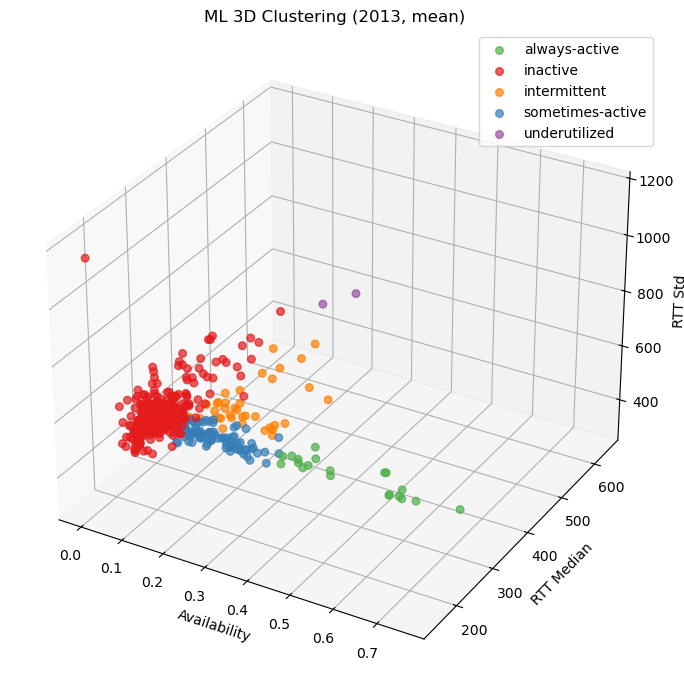

In [29]:
plot_3d_clusters(ml3d_mean_cls_2013_final, block_stats_2013, year='2013', stat='mean')

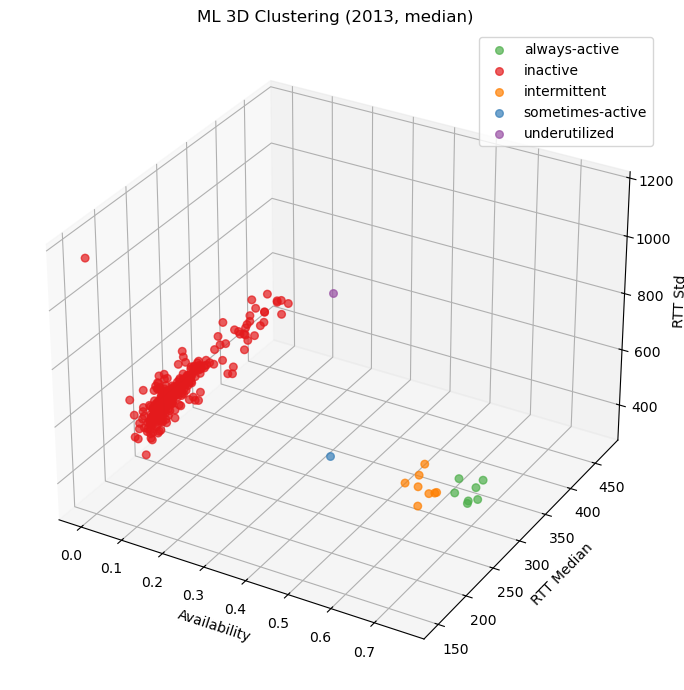

In [30]:
plot_3d_clusters(ml3d_median_cls_2013_final, block_stats_2013, year='2013', stat='median')

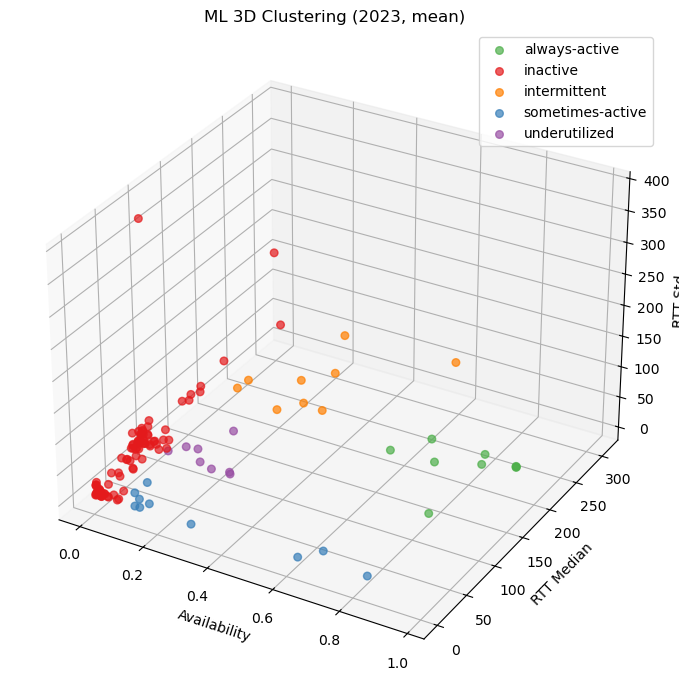

In [31]:
plot_3d_clusters(ml3d_mean_cls_2023_final, block_stats_2023, year='2023', stat='mean')

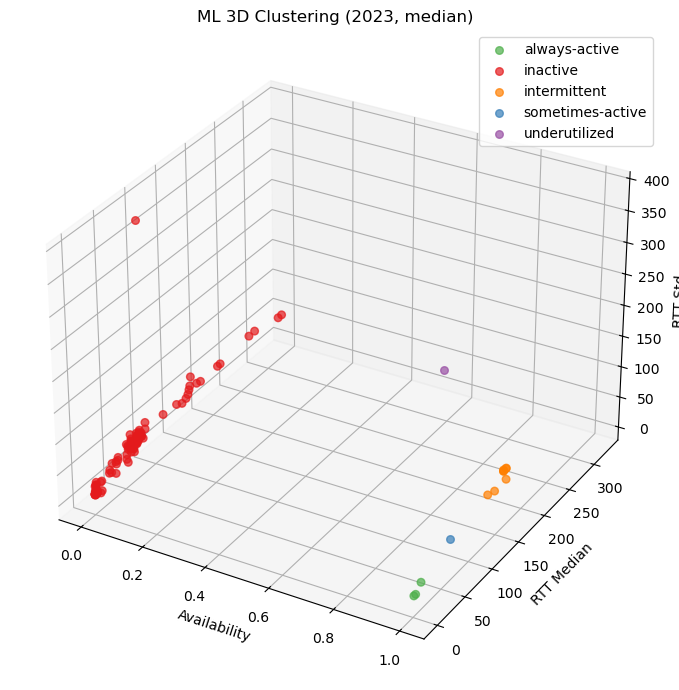

In [32]:
plot_3d_clusters(ml3d_median_cls_2023_final, block_stats_2023, year='2023', stat='median')

In [33]:
def plot_pairwise_2d(df_cls, stats_df, year, stat='mean'):
    import seaborn as sns
    import matplotlib.pyplot as plt

    df_plot = df_cls.merge(
        stats_df[[
            'block24',
            f'availability_{stat}',
            f'rtt_median_{stat}',
            f'rtt_std_{stat}'
        ]],
        on='block24', how='left'
    )

    df_plot = df_plot.rename(columns={
        f'availability_{stat}': 'Availability',
        f'rtt_median_{stat}': 'RTT_Median',
        f'rtt_std_{stat}': 'RTT_Std'
    })

    sns.pairplot(
        df_plot,
        hue='category',
        vars=['Availability', 'RTT_Median', 'RTT_Std'],
        plot_kws={'alpha': 0.6, 's': 40}
    )
    plt.suptitle(f"{year} ML-3D Pairwise View ({stat})", y=1.02)
    plt.show()

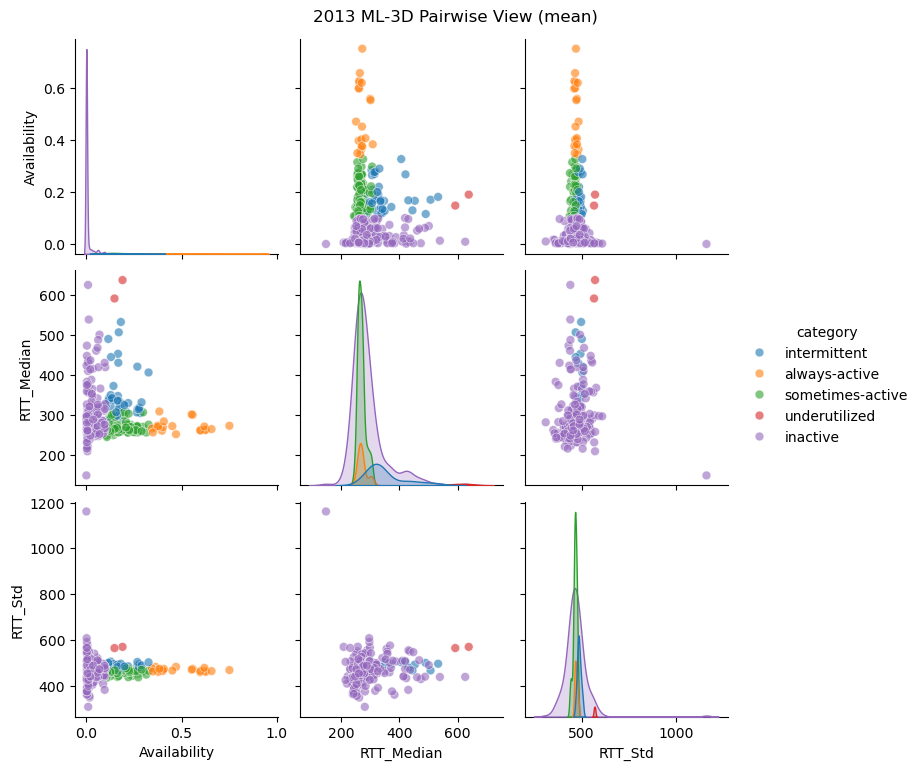

In [34]:
plot_pairwise_2d(ml3d_mean_cls_2013_final, block_stats_2013, year='2013', stat='mean')

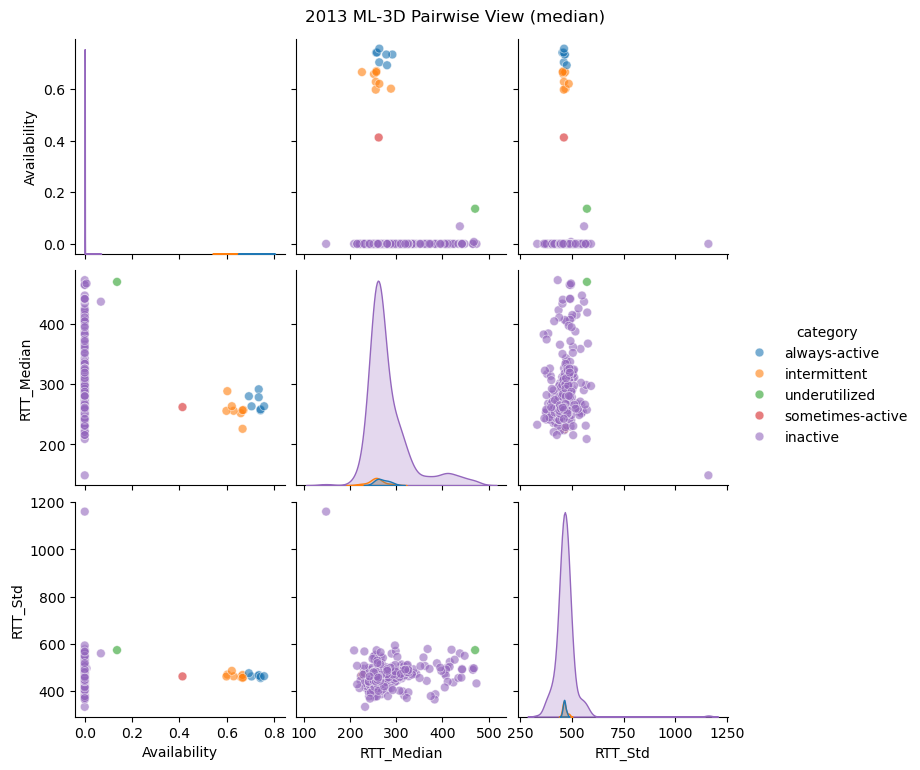

In [35]:
plot_pairwise_2d(ml3d_median_cls_2013_final, block_stats_2013, year='2013', stat='median')

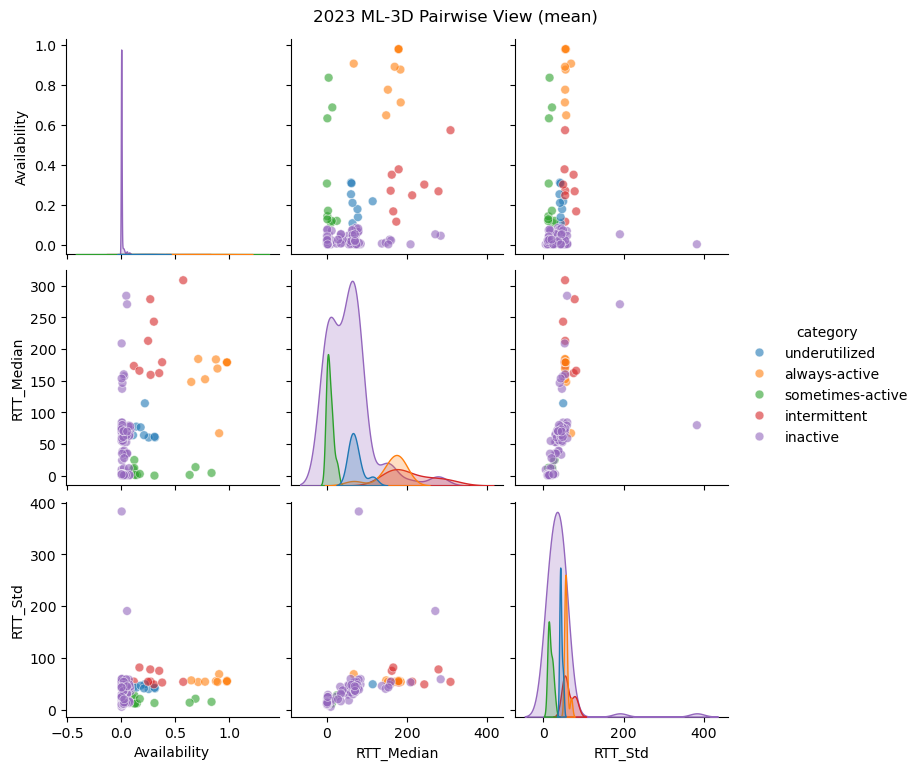

In [36]:
plot_pairwise_2d(ml3d_mean_cls_2023_final, block_stats_2023, year='2023', stat='mean')

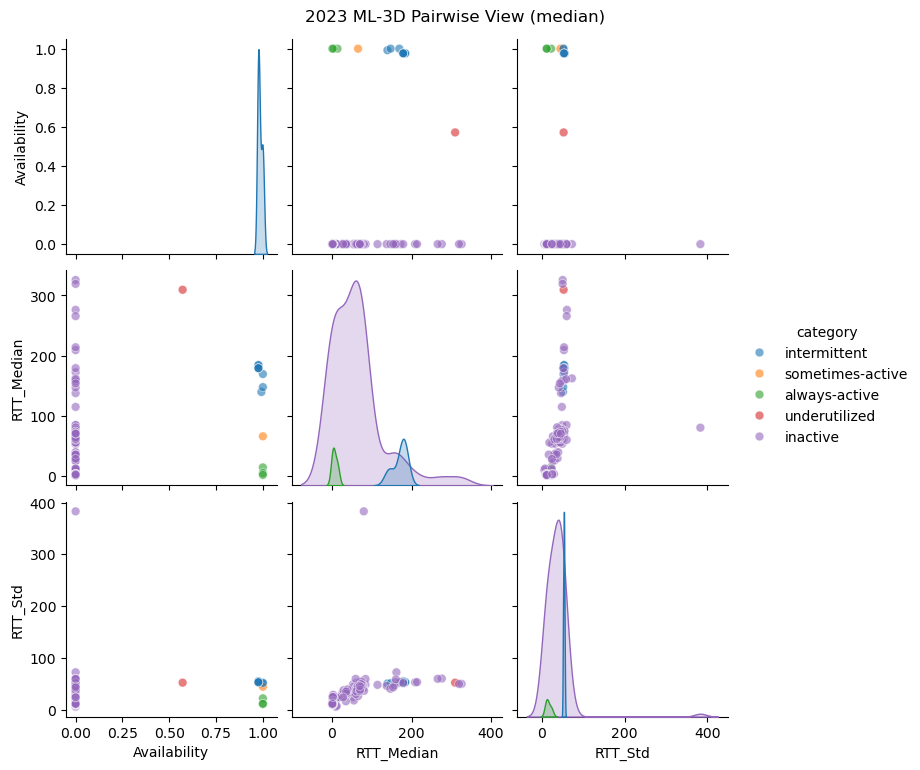

In [37]:
plot_pairwise_2d(ml3d_median_cls_2023_final, block_stats_2023, year='2023', stat='median')

In [38]:
cai_renamed_2013 = cai_median_cls_2013_strict.copy()
cai_renamed_2013['cai_median_category_2013_strict'] = cai_renamed_2013['cai_median_category_2013_strict'].replace({
    'unclassifiable': 'inactive',
    'underutilized': 'underutilized',
    'always‑stable': 'always‑active',
    'sometimes‑stable': 'sometimes‑active',
    'intermittent': 'intermittent'
})

In [39]:
cmp13 = (
    block_stats_2013[['block24', 'availability_median', 'rtt_std_median']]
    .merge(block_stats_2013[['block24', 'availability_mean', 'rtt_std_mean']],
           on='block24', how='left')
    .merge(cai_renamed_2013[['block24', 'cai_median_category_2013_strict']],
           on='block24', how='left')
    .merge(ml3d_mean_cls_2013_final[['block24', 'category']],
           on='block24', how='left')
    .rename(columns={
        'availability_median': 'availability_Cai',
        'rtt_std_median': 'rtt_std_Cai',
        'availability_mean': 'availability_ML',
        'rtt_std_mean': 'rtt_std_ML',
        'cai_median_category_2013_strict': 'Cai',
        'category': 'ML'
    })
)

In [40]:
ct13 = pd.crosstab(cmp13['Cai'], cmp13['ML'])
print("Cai vs ML (2013):")
print(ct13)

Cai vs ML (2013):
ML             always‑active  inactive  intermittent  sometimes‑active  \
Cai                                                                      
inactive                   0      1438            10                32   
intermittent              16         0             0                 0   
underutilized              4         2            28                57   

ML             underutilized  
Cai                           
inactive                   0  
intermittent               1  
underutilized              1  


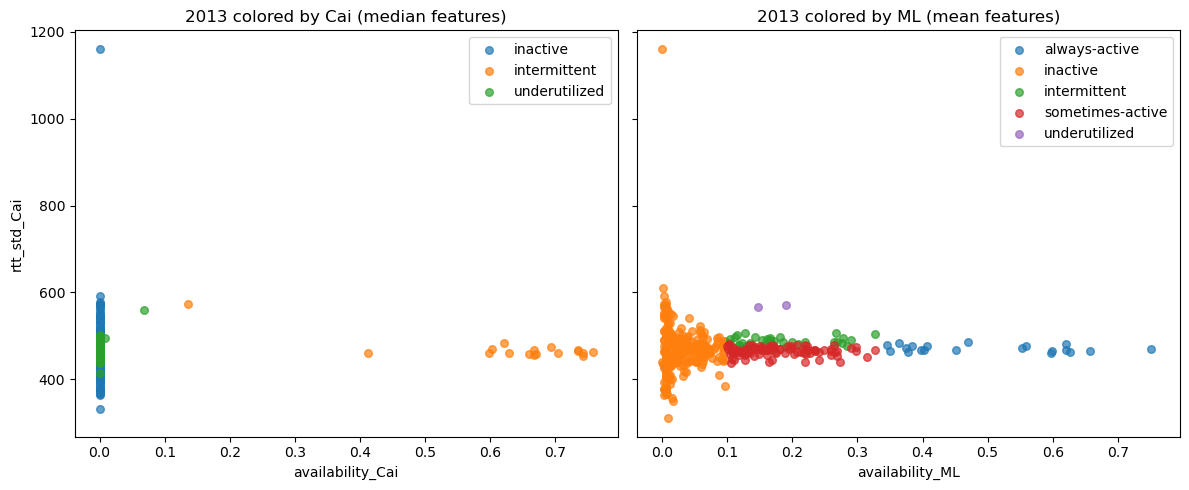

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

for lab, dfg in cmp13.groupby('Cai'):
    axes[0].scatter(dfg['availability_Cai'],
                    dfg['rtt_std_Cai'],
                    label=lab, alpha=0.7, s=30)
axes[0].set_title('2013 colored by Cai (median features)')
axes[0].set_xlabel('availability_Cai')
axes[0].set_ylabel('rtt_std_Cai')
axes[0].legend()

for lab, dfg in cmp13.groupby('ML'):
    axes[1].scatter(dfg['availability_ML'],
                    dfg['rtt_std_ML'],
                    label=lab, alpha=0.7, s=30)
axes[1].set_title('2013 colored by ML (mean features)')
axes[1].set_xlabel('availability_ML')
axes[1].legend()

plt.tight_layout()
plt.show()

In [42]:
cai_renamed_mean_2013 = cai_mean_cls_2013_strict.copy()
cai_renamed_mean_2013['cai_mean_category_2013_strict'] = cai_renamed_mean_2013['cai_mean_category_2013_strict'].replace({
    'unclassifiable': 'inactive',
    'underutilized': 'underutilized',
    'always‑stable': 'always‑active',
    'sometimes‑stable': 'sometimes‑active',
    'intermittent': 'intermittent'
})

cmp13_mean = (
    block_stats_2013[['block24', 'availability_mean', 'rtt_std_mean']]
    .merge(cai_renamed_mean_2013[['block24', 'cai_mean_category_2013_strict']],
           on='block24', how='left')
    .merge(ml3d_mean_cls_2013_final[['block24', 'category']],
           on='block24', how='left')
    .rename(columns={
        'cai_mean_category_2013_strict': 'Cai',
        'category': 'ML'
    })
)

ct13_mean = pd.crosstab(cmp13_mean['Cai'], cmp13_mean['ML'])
print("Cai vs ML (2013, mean):")
print(ct13_mean)

Cai vs ML (2013, mean):
ML             always‑active  inactive  intermittent  sometimes‑active  \
Cai                                                                      
inactive                   0      1438            10                32   
intermittent              20         0            28                57   
underutilized              0         2             0                 0   

ML             underutilized  
Cai                           
inactive                   0  
intermittent               2  
underutilized              0  


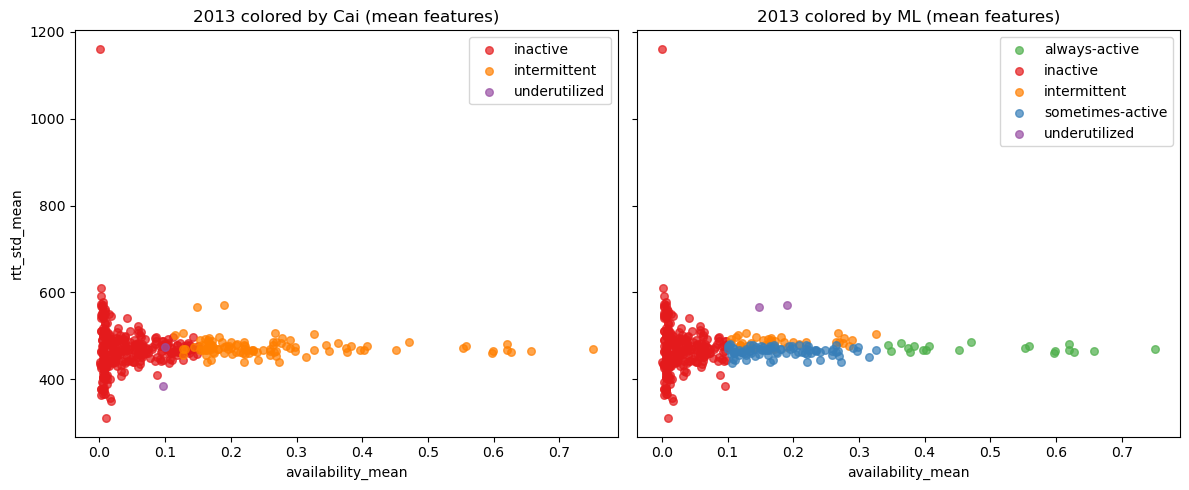

In [43]:
label_colors = {
    'inactive': '#e41a1c',
    'always‑active': '#4daf4a',
    'sometimes‑active': '#377eb8',
    'intermittent': '#ff7f00',
    'underutilized': '#984ea3'
}

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

for lab, dfg in cmp13_mean.groupby('Cai'):
    axes[0].scatter(dfg['availability_mean'],
                    dfg['rtt_std_mean'],
                    label=lab,
                    alpha=0.7,
                    s=30,
                    color=label_colors.get(lab, 'gray'))
axes[0].set_title('2013 colored by Cai (mean features)')
axes[0].set_xlabel('availability_mean')
axes[0].set_ylabel('rtt_std_mean')
axes[0].legend()

for lab, dfg in cmp13_mean.groupby('ML'):
    axes[1].scatter(dfg['availability_mean'],
                    dfg['rtt_std_mean'],
                    label=lab,
                    alpha=0.7,
                    s=30,
                    color=label_colors.get(lab, 'gray'))
axes[1].set_title('2013 colored by ML (mean features)')
axes[1].set_xlabel('availability_mean')
axes[1].legend()

plt.tight_layout()
plt.show()

Cai vs ML (2023, mean):
ML                always‑active  inactive  intermittent  sometimes‑active  \
Cai                                                                         
inactive                      0       607             2                 6   
intermittent                  0         0             5                 0   
sometimes‑active              9         0             2                 4   

ML                underutilized  
Cai                              
inactive                      3  
intermittent                  2  
sometimes‑active              3  


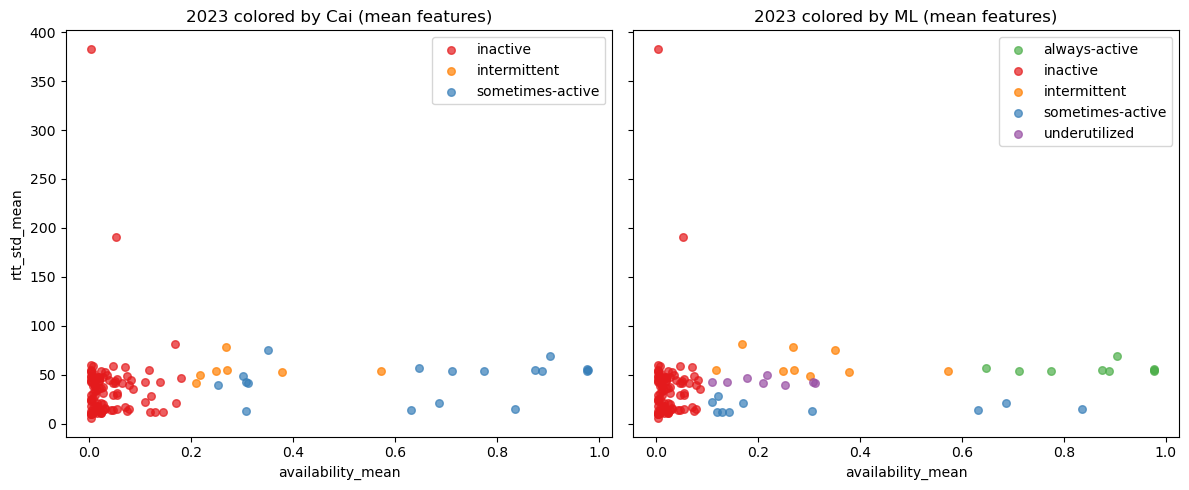

In [44]:
cai_renamed_mean_2023 = cai_mean_cls_2023_strict.copy()
cai_renamed_mean_2023['cai_mean_category_2023_strict'] = cai_renamed_mean_2023['cai_mean_category_2023_strict'].replace({
    'unclassifiable': 'inactive',
    'underutilized': 'underutilized',
    'always‑stable': 'always‑active',
    'sometimes‑stable': 'sometimes‑active',
    'intermittent': 'intermittent'
})

cmp23_mean = (
    block_stats_2023[['block24', 'availability_mean', 'rtt_std_mean']]
    .merge(cai_renamed_mean_2023[['block24', 'cai_mean_category_2023_strict']],
           on='block24', how='left')
    .merge(ml3d_mean_cls_2023_final[['block24', 'category']],
           on='block24', how='left')
    .rename(columns={
        'cai_mean_category_2023_strict': 'Cai',
        'category': 'ML'
    })
)

ct23_mean = pd.crosstab(cmp23_mean['Cai'], cmp23_mean['ML'])
print("Cai vs ML (2023, mean):")
print(ct23_mean)

label_colors = {
    'inactive': '#e41a1c',
    'always‑active': '#4daf4a',
    'sometimes‑active': '#377eb8',
    'intermittent': '#ff7f00',
    'underutilized': '#984ea3'
}

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

for lab, dfg in cmp23_mean.groupby('Cai'):
    axes[0].scatter(dfg['availability_mean'],
                    dfg['rtt_std_mean'],
                    label=lab,
                    alpha=0.7,
                    s=30,
                    color=label_colors.get(lab, 'gray'))
axes[0].set_title('2023 colored by Cai (mean features)')
axes[0].set_xlabel('availability_mean')
axes[0].set_ylabel('rtt_std_mean')
axes[0].legend()

for lab, dfg in cmp23_mean.groupby('ML'):
    axes[1].scatter(dfg['availability_mean'],
                    dfg['rtt_std_mean'],
                    label=lab,
                    alpha=0.7,
                    s=30,
                    color=label_colors.get(lab, 'gray'))
axes[1].set_title('2023 colored by ML (mean features)')
axes[1].set_xlabel('availability_mean')
axes[1].legend()

plt.tight_layout()
plt.show()

# Using Only 2 Features

In [45]:
import ipaddress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import timedelta
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


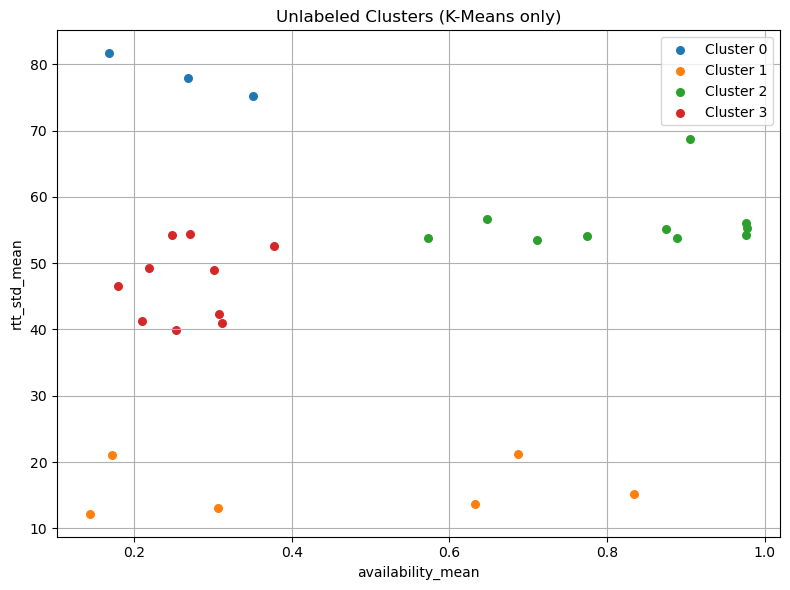

In [46]:
filtered = block_stats_2023[block_stats_2023['availability_mean'] >= 0.14].dropna(subset=['rtt_std_mean'])

X = filtered[['availability_mean', 'rtt_std_mean']].copy()
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
filtered['cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
for cid, group in filtered.groupby('cluster'):
    plt.scatter(group['availability_mean'], group['rtt_std_mean'], label=f'Cluster {cid}', s=30)

plt.xlabel('availability_mean')
plt.ylabel('rtt_std_mean')
plt.title('Unlabeled Clusters (K-Means only)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

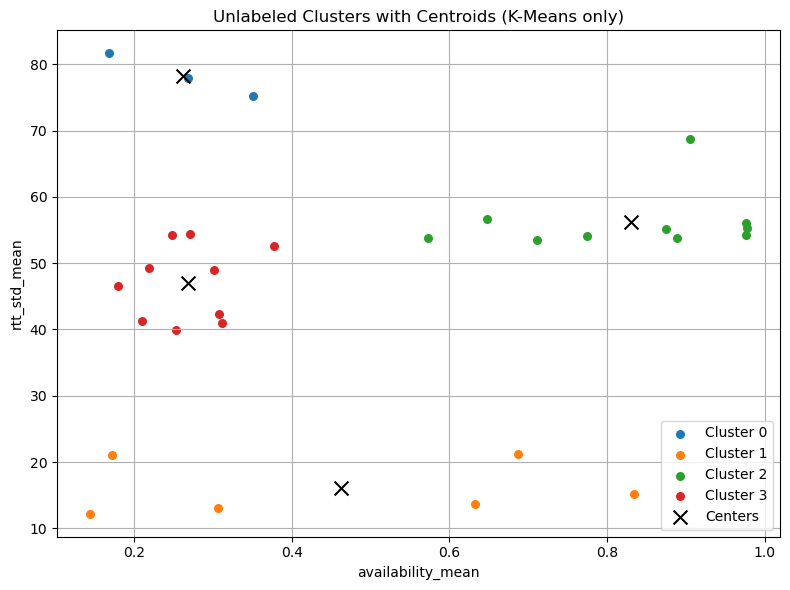

In [47]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['availability_scaled', 'rtt_std_scaled'])
centers_original = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=['availability_mean', 'rtt_std_mean']
)

plt.figure(figsize=(8,6))
for cid, group in filtered.groupby('cluster'):
    plt.scatter(group['availability_mean'], group['rtt_std_mean'], label=f'Cluster {cid}', s=30)

plt.scatter(centers_original['availability_mean'], centers_original['rtt_std_mean'], 
            marker='x', color='black', s=100, label='Centers')

plt.xlabel('availability_mean')
plt.ylabel('rtt_std_mean')
plt.title('Unlabeled Clusters with Centroids (K-Means only)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
def classify_blocks_ml_2d(
    blocks_df,
    avail_col,
    rtt_std_col,
    inactive_thresh=0.1,
    n_clusters=4
):
    df = blocks_df[['block24', avail_col, rtt_std_col]].copy()
    df.columns = ['block24', 'availability', 'rtt_std']

    inactive = df[df['availability'] < inactive_thresh].copy()
    inactive['category'] = 'inactive'

    active = df[df['availability'] >= inactive_thresh].copy()
    active = active.dropna()

    X = active[['availability', 'rtt_std']].values
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)

    km = KMeans(n_clusters=n_clusters, random_state=42).fit(X_scaled)
    active['cluster_id'] = km.labels_

    silhouette = silhouette_score(X_scaled, km.labels_)
    print(f"Silhouette score (2D): {silhouette:.3f}")

    centers = pd.DataFrame(
        scaler.inverse_transform(km.cluster_centers_),
        columns=['availability', 'rtt_std']
    )
    centers['cluster_id'] = centers.index

    always_active_idx = centers.sort_values(['availability', 'rtt_std'], ascending=[False, True]).iloc[0]['cluster_id']
    underutilized_idx = centers['availability'].idxmin()

    remaining = centers[~centers['cluster_id'].isin([always_active_idx, underutilized_idx])]

    remaining_sorted = remaining.sort_values(['availability', 'rtt_std'], ascending=[False, False])
    intermittent_idx = remaining_sorted.iloc[0]['cluster_id']
    sometimes_active_idx = remaining_sorted.iloc[1]['cluster_id']

    mapping = {
        always_active_idx: 'always‑active',
        underutilized_idx: 'underutilized',
        intermittent_idx: 'intermittent',
        sometimes_active_idx: 'sometimes‑active'
    }

    active['category'] = active['cluster_id'].map(mapping)

    return pd.concat([
        active[['block24', 'category']],
        inactive[['block24', 'category']]
    ], ignore_index=True)

In [49]:
inactive_thresholds = [0.01, 0.05, 0.10, 0.15, 0.20]

for inactive_thresh in inactive_thresholds:
    print(f"\n=== ML (2D) sweep: inactive_thresh={inactive_thresh:.2f} ===")
    for year, bs in [('2013', block_stats_2013), ('2023', block_stats_2023)]:
        for stat in ['median', 'mean']:
            result = classify_blocks_ml_2d(
                bs,
                avail_col=f'availability_{stat}',
                rtt_std_col=f'rtt_std_{stat}',
                inactive_thresh=inactive_thresh
            )
            print(f"  ML‑2D‑{stat}‑{year}:", result['category'].value_counts().to_dict())


=== ML (2D) sweep: inactive_thresh=0.01 ===
Silhouette score (2D): 0.393
  ML‑2D‑median‑2013: {'inactive': 1571, 'always‑active': 9, 'intermittent': 6, 'underutilized': 2, 'sometimes‑active': 1}
Silhouette score (2D): 0.379
  ML‑2D‑mean‑2013: {'inactive': 1284, 'intermittent': 108, 'sometimes‑active': 105, 'underutilized': 74, 'always‑active': 18}
Silhouette score (2D): 0.746
  ML‑2D‑median‑2023: {'inactive': 630, 'sometimes‑active': 9, 'always‑active': 2, 'intermittent': 1, 'underutilized': 1}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score (2D): 0.523
  ML‑2D‑mean‑2023: {'inactive': 549, 'intermittent': 47, 'sometimes‑active': 33, 'always‑active': 13, 'underutilized': 1}

=== ML (2D) sweep: inactive_thresh=0.05 ===
Silhouette score (2D): 0.393
  ML‑2D‑median‑2013: {'inactive': 1571, 'always‑active': 9, 'intermittent': 6, 'underutilized': 2, 'sometimes‑active': 1}
Silhouette score (2D): 0.386
  ML‑2D‑mean‑2013: {'inactive': 1373, 'intermittent': 132, 'underutilized': 33, 'sometimes‑active': 29, 'always‑active': 22}
Silhouette score (2D): 0.746
  ML‑2D‑median‑2023: {'inactive': 630, 'sometimes‑active': 9, 'always‑active': 2, 'intermittent': 1, 'underutilized': 1}
Silhouette score (2D): 0.489
  ML‑2D‑mean‑2023: {'inactive': 591, 'intermittent': 25, 'always‑active': 13, 'sometimes‑active': 13, 'underutilized': 1}

=== ML (2D) sweep: inactive_thresh=0.10 ===
Silhouette score (2D): 0.317
  ML‑2D‑median‑2013: {'inactive': 1572, 'always‑active': 9, 'intermittent': 6, 'underutilized': 1, 'sometimes‑active': 1}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

Silhouette score (2D): 0.394
  ML‑2D‑mean‑2013: {'inactive': 1440, 'sometimes‑active': 73, 'intermittent': 54, 'always‑active': 20, 'underutilized': 2}
Silhouette score (2D): 0.746
  ML‑2D‑median‑2023: {'inactive': 630, 'sometimes‑active': 9, 'always‑active': 2, 'intermittent': 1, 'underutilized': 1}
Silhouette score (2D): 0.577
  ML‑2D‑mean‑2023: {'inactive': 607, 'sometimes‑active': 16, 'always‑active': 10, 'underutilized': 7, 'intermittent': 3}

=== ML (2D) sweep: inactive_thresh=0.15 ===
Silhouette score (2D): 0.273
  ML‑2D‑median‑2013: {'inactive': 1573, 'intermittent': 9, 'always‑active': 5, 'underutilized': 1, 'sometimes‑active': 1}
Silhouette score (2D): 0.392
  ML‑2D‑mean‑2013: {'inactive': 1488, 'intermittent': 48, 'sometimes‑active': 40, 'always‑active': 12, 'underutilized': 1}
Silhouette score (2D): 0.746
  ML‑2D‑median‑2023: {'inactive': 630, 'sometimes‑active': 9, 'always‑active': 2, 'intermittent': 1, 'underutilized': 1}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

Silhouette score (2D): 0.611
  ML‑2D‑mean‑2023: {'inactive': 615, 'sometimes‑active': 10, 'always‑active': 10, 'intermittent': 5, 'underutilized': 3}

=== ML (2D) sweep: inactive_thresh=0.20 ===
Silhouette score (2D): 0.273
  ML‑2D‑median‑2013: {'inactive': 1573, 'intermittent': 9, 'always‑active': 5, 'underutilized': 1, 'sometimes‑active': 1}
Silhouette score (2D): 0.408
  ML‑2D‑mean‑2013: {'inactive': 1527, 'intermittent': 30, 'sometimes‑active': 15, 'always‑active': 9, 'underutilized': 8}
Silhouette score (2D): 0.746
  ML‑2D‑median‑2023: {'inactive': 630, 'sometimes‑active': 9, 'always‑active': 2, 'intermittent': 1, 'underutilized': 1}
Silhouette score (2D): 0.639
  ML‑2D‑mean‑2023: {'inactive': 618, 'always‑active': 10, 'underutilized': 9, 'intermittent': 4, 'sometimes‑active': 2}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Selecting the Threshold

Why did we select inactive_thresh = 0.10 for ML‑2D clustering? We evaluated multiple thresholds (0.01 to 0.20) to determine the cutoff for marking blocks as inactive based on low availability. Our decision to select 0.10 was guided by two key criteria:

1. Visual interpretability of clusters: At inactive_thresh = 0.10, the remaining blocks formed clearly distinguishable groups across both availability and RTT variability. This allowed for meaningful behavioral labels like always‑active, sometimes‑active, and intermittent to emerge without excessive overlap or sparsity.

2. Balanced clustering performance: While lower thresholds had slightly higher silhouette scores, 0.10 offered a strong compromise between cohesive cluster formation and preserving enough data to support robust labeling across all five categories.

In [50]:
best_inactive = 0.10

print("ml2d_median_cls_2013_final")
ml2d_median_cls_2013_final = classify_blocks_ml_2d(
    block_stats_2013,
    avail_col='availability_median',
    rtt_std_col='rtt_std_median',
    inactive_thresh=best_inactive
)

print("\nml2d_mean_cls_2013_final")
ml2d_mean_cls_2013_final = classify_blocks_ml_2d(
    block_stats_2013,
    avail_col='availability_mean',
    rtt_std_col='rtt_std_mean',
    inactive_thresh=best_inactive
)

print("\nml2d_median_cls_2023_final")
ml2d_median_cls_2023_final = classify_blocks_ml_2d(
    block_stats_2023,
    avail_col='availability_median',
    rtt_std_col='rtt_std_median',
    inactive_thresh=best_inactive
)

print("\nml2d_mean_cls_2023_final")
ml2d_mean_cls_2023_final = classify_blocks_ml_2d(
    block_stats_2023,
    avail_col='availability_mean',
    rtt_std_col='rtt_std_mean',
    inactive_thresh=best_inactive
)

ml2d_median_cls_2013_final
Silhouette score (2D): 0.317

ml2d_mean_cls_2013_final


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score (2D): 0.394

ml2d_median_cls_2023_final
Silhouette score (2D): 0.746

ml2d_mean_cls_2023_final
Silhouette score (2D): 0.577


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [51]:
cai_mean_renamed_2013_2d = cai_mean_cls_2013_strict.copy()
cai_mean_renamed_2013_2d['cai_mean_category_2013_strict'] = cai_mean_renamed_2013_2d['cai_mean_category_2013_strict'].replace({
    'unclassifiable': 'inactive',
    'underutilized': 'underutilized',
    'always‑stable': 'always‑active',
    'sometimes‑stable': 'sometimes‑active',
    'intermittent': 'intermittent'
})

cmp13_mean_2d = (
    block_stats_2013[['block24', 'availability_mean', 'rtt_std_mean']]
    .merge(cai_mean_renamed_2013_2d[['block24', 'cai_mean_category_2013_strict']],
           on='block24', how='left')
    .merge(ml2d_mean_cls_2013_final[['block24', 'category']],
           on='block24', how='left')
    .rename(columns={
        'cai_mean_category_2013_strict': 'Cai_2D',
        'category': 'ML_2D'
    })
)

ct13_mean_2d = pd.crosstab(cmp13_mean_2d['Cai_2D'], cmp13_mean_2d['ML_2D'])
print("Cai (mean) vs ML 2D (2013):")
print(ct13_mean_2d)

Cai (mean) vs ML 2D (2013):
ML_2D          always‑active  inactive  intermittent  sometimes‑active  \
Cai_2D                                                                   
inactive                   0      1438            15                27   
intermittent              20         0            39                46   
underutilized              0         2             0                 0   

ML_2D          underutilized  
Cai_2D                        
inactive                   0  
intermittent               2  
underutilized              0  


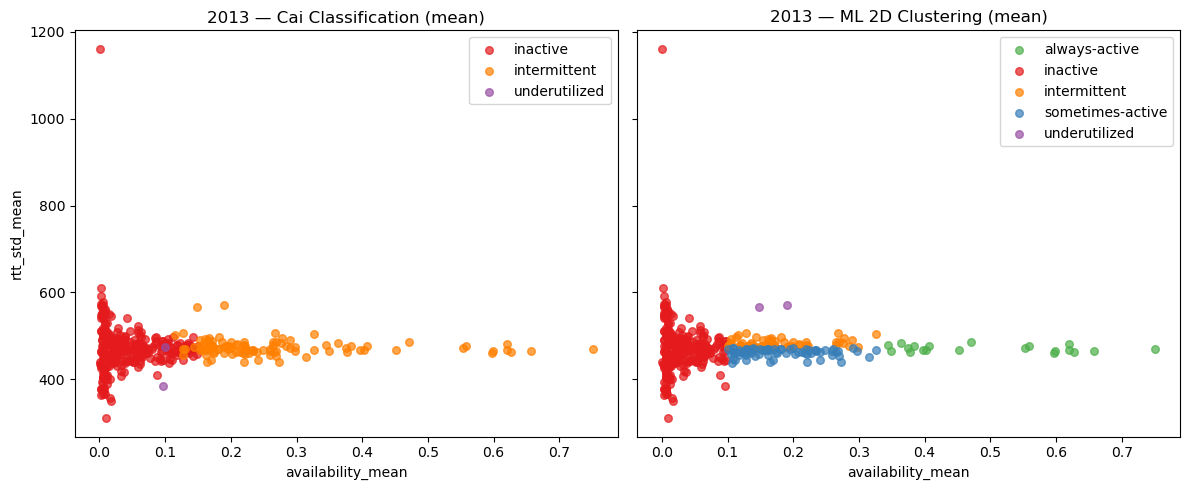

In [52]:
label_colors = {
    'inactive': '#e41a1c',
    'always‑active': '#4daf4a',
    'sometimes‑active': '#377eb8',
    'intermittent': '#ff7f00',
    'underutilized': '#984ea3'
}

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

for label, group in cmp13_mean_2d.groupby('Cai_2D'):
    axes[0].scatter(group['availability_mean'],
                    group['rtt_std_mean'],
                    label=label,
                    alpha=0.7,
                    s=30,
                    color=label_colors.get(label, 'gray'))
axes[0].set_title('2013 — Cai Classification (mean)')
axes[0].set_xlabel('availability_mean')
axes[0].set_ylabel('rtt_std_mean')
axes[0].legend()

for label, group in cmp13_mean_2d.groupby('ML_2D'):
    axes[1].scatter(group['availability_mean'],
                    group['rtt_std_mean'],
                    label=label,
                    alpha=0.7,
                    s=30,
                    color=label_colors.get(label, 'gray'))
axes[1].set_title('2013 — ML 2D Clustering (mean)')
axes[1].set_xlabel('availability_mean')
axes[1].legend()

plt.tight_layout()
plt.show()

## Comparison Summary (2013)

In 2013, Cai's rule-based classification and our ML 2D clustering produced visibly different distributions. While both methods identified large inactive clusters, Cai’s model emphasized rtt_std thresholds (vertical separation), grouping blocks with high variability as intermittent even when availability was low. In contrast, ML 2D used centroid-based grouping, which considered both availability and variability simultaneously. This led to the emergence of a sometimes-active class that was absent in Cai’s output — possibly due to hardcoded threshold rules in the paper that suppressed that class in noisier data.

This divergence reflects a conceptual difference: Cai's model rigidly applies formulas, whereas ML 2D lets the data shape the behavior-based categories. For instance, a block with medium availability and moderate RTT variation might straddle two rules in Cai's logic but fall confidently into the sometimes-active region via clustering. This adaptability may offer better generalization for real-world performance characterization, especially as address dynamics evolve over time.

In [53]:
cai_mean_renamed_2023_2d = cai_mean_cls_2023_strict.copy()
cai_mean_renamed_2023_2d['cai_mean_category_2023_strict'] = cai_mean_renamed_2023_2d['cai_mean_category_2023_strict'].replace({
    'unclassifiable': 'inactive',
    'underutilized': 'underutilized',
    'always‑stable': 'always‑active',
    'sometimes‑stable': 'sometimes‑active',
    'intermittent': 'intermittent'
})

cmp23_mean_2d = (
    block_stats_2023[['block24', 'availability_mean', 'rtt_std_mean']]
    .merge(cai_mean_renamed_2023_2d[['block24', 'cai_mean_category_2023_strict']],
           on='block24', how='left')
    .merge(ml2d_mean_cls_2023_final[['block24', 'category']],
           on='block24', how='left')
    .rename(columns={
        'cai_mean_category_2023_strict': 'Cai_2D',
        'category': 'ML_2D'
    })
)

ct23_mean_2d = pd.crosstab(cmp23_mean_2d['Cai_2D'], cmp23_mean_2d['ML_2D'])
print("Cai (mean) vs ML 2D (2023):")
print(ct23_mean_2d)

Cai (mean) vs ML 2D (2023):
ML_2D             always‑active  inactive  intermittent  sometimes‑active  \
Cai_2D                                                                      
inactive                      0       607             0                 5   
intermittent                  1         0             0                 6   
sometimes‑active              9         0             3                 5   

ML_2D             underutilized  
Cai_2D                           
inactive                      6  
intermittent                  0  
sometimes‑active              1  


/var/folders/8r/lfyf0ss51773c4jxqfwp0m600000gn/T/ipykernel_30102/545374653.py:34: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  axes[0].legend(title="Cai", loc='best', handles=sorted(axes[0].get_legend().legendHandles, key=lambda h: h.get_label()))
/var/folders/8r/lfyf0ss51773c4jxqfwp0m600000gn/T/ipykernel_30102/545374653.py:35: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  axes[1].legend(title="ML 2D", loc='best', handles=sorted(axes[1].get_legend().legendHandles, key=lambda h: h.get_label()))


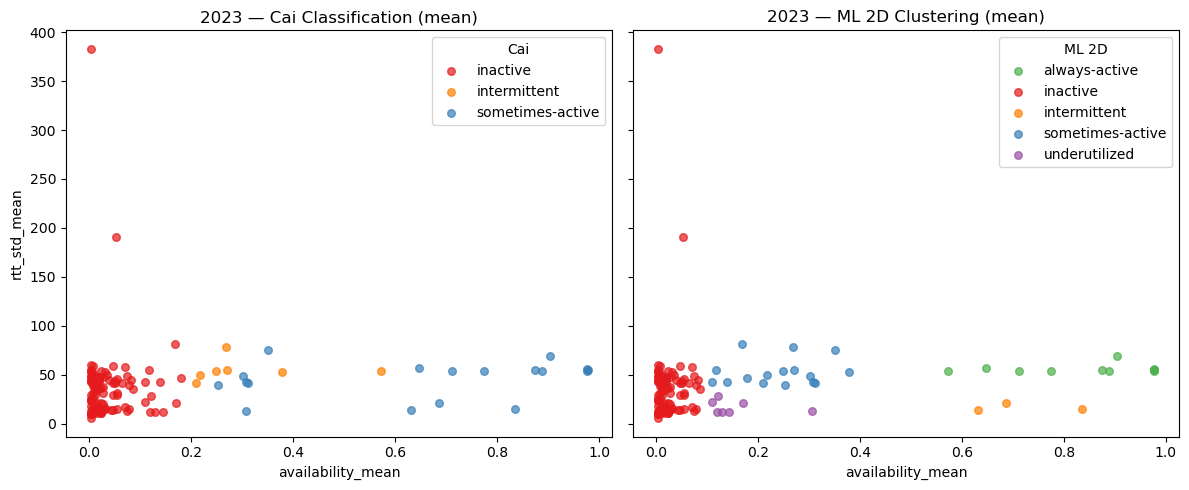

In [54]:
label_colors = {
    'inactive': '#e41a1c',
    'always‑active': '#4daf4a',
    'sometimes‑active': '#377eb8',
    'intermittent': '#ff7f00',
    'underutilized': '#984ea3'
}

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

for label, group in cmp23_mean_2d.groupby('Cai_2D'):
    axes[0].scatter(group['availability_mean'],
                    group['rtt_std_mean'],
                    label=label,
                    alpha=0.7,
                    s=30,
                    color=label_colors.get(label, 'gray'))
axes[0].set_title('2023 — Cai Classification (mean)')
axes[0].set_xlabel('availability_mean')
axes[0].set_ylabel('rtt_std_mean')
axes[0].legend()

for label, group in cmp23_mean_2d.groupby('ML_2D'):
    axes[1].scatter(group['availability_mean'],
                    group['rtt_std_mean'],
                    label=label,
                    alpha=0.7,
                    s=30,
                    color=label_colors.get(label, 'gray'))
axes[1].set_title('2023 — ML 2D Clustering (mean)')
axes[1].set_xlabel('availability_mean')
axes[1].legend()

axes[0].legend(title="Cai", loc='best', handles=sorted(axes[0].get_legend().legendHandles, key=lambda h: h.get_label()))
axes[1].legend(title="ML 2D", loc='best', handles=sorted(axes[1].get_legend().legendHandles, key=lambda h: h.get_label()))

plt.tight_layout()
plt.show()

## Comparison Summary (2023)

In 2023, the difference between Cai’s and ML 2D classifications became especially pronounced. Cai’s method tended to over-label addresses with low availability as inactive, even if their RTT behaviors were closer to stable patterns. The ML 2D approach, however, captured more nuance: it separated low-availability blocks with stable RTT into a distinct underutilized class, and preserved the distinction between sometimes-active and intermittent at higher availability.

For example, blocks around availability 0.6–0.8 were labeled sometimes-active or intermittent by ML, depending on their RTT variability, while Cai’s rules grouped many of these into intermittent or even inactive. This illustrates how a clustering-based method may better reflect evolving Internet usage — especially when traditional rule thresholds fail to account for subtle but important patterns in combined metrics.

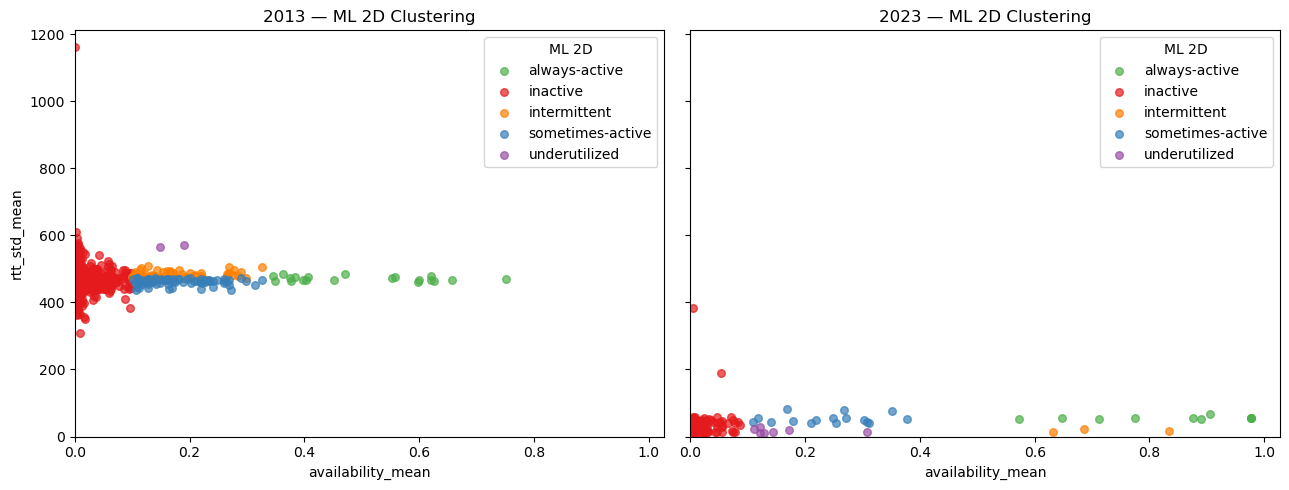

In [55]:
ml_cmp_2013_viz = (
    block_stats_2013[['block24', 'availability_mean', 'rtt_std_mean']]
    .merge(ml2d_mean_cls_2013_final[['block24', 'category']],
           on='block24', how='left')
    .rename(columns={'category': 'ML2D_2013'})
)

ml_cmp_2023_viz = (
    block_stats_2023[['block24', 'availability_mean', 'rtt_std_mean']]
    .merge(ml2d_mean_cls_2023_final[['block24', 'category']],
           on='block24', how='left')
    .rename(columns={'category': 'ML2D_2023'})
)

ml2d_color_map = {
    'inactive': '#e41a1c',
    'always‑active': '#4daf4a',
    'sometimes‑active': '#377eb8',
    'intermittent': '#ff7f00',
    'underutilized': '#984ea3'
}

x_min = 0
x_max = max(
    ml_cmp_2013_viz['availability_mean'].max(),
    ml_cmp_2023_viz['availability_mean'].max()
) + 0.05
y_max = max(
    ml_cmp_2013_viz['rtt_std_mean'].max(),
    ml_cmp_2023_viz['rtt_std_mean'].max()
) + 50

fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharex=True, sharey=True)

# — 2013
for label, group in ml_cmp_2013_viz.groupby('ML2D_2013'):
    axes[0].scatter(group['availability_mean'], group['rtt_std_mean'],
                    label=label, color=ml2d_color_map.get(label, 'gray'), s=30, alpha=0.7)
axes[0].set_title('2013 — ML 2D Clustering')
axes[0].set_xlabel('availability_mean')
axes[0].set_ylabel('rtt_std_mean')
axes[0].legend(title="ML 2D")
axes[0].set_xlim([x_min, x_max])
axes[0].set_ylim([0, y_max])

# — 2023
for label, group in ml_cmp_2023_viz.groupby('ML2D_2023'):
    axes[1].scatter(group['availability_mean'], group['rtt_std_mean'],
                    label=label, color=ml2d_color_map.get(label, 'gray'), s=30, alpha=0.7)
axes[1].set_title('2023 — ML 2D Clustering')
axes[1].set_xlabel('availability_mean')
axes[1].legend(title="ML 2D")
axes[1].set_xlim([x_min, x_max])
axes[1].set_ylim([0, y_max])

plt.tight_layout()
plt.show()